## Imports

In [3]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from kerasAC.splits import *
from viz_preprocess import *
from viz_sequence import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

np.random.seed(1234)
plt.style.use('default')

## Prepare Inputs

In [4]:
input_bed = pd.read_csv('/srv/www/encode4crisprhack/gkmexplain/inputs/caprin_promoters_dnase_intersection.hg38.input.bed', header=None, sep='\t')
input_chrom = input_bed[0].tolist()
input_start = input_bed[1].tolist()
input_end = input_bed[2].tolist()

fasta = '/srv/www/encode4crisprhack/gkmexplain/inputs/caprin_promoters_dnase_intersection.hg38.input.fa'
hyp_file = '/srv/www/encode4crisprhack/gkmexplain/outputs/caprin_promoters_dnase_intersection.hg38.hyp.scores'

seqs = [x.rstrip() for (i,x) in enumerate(open(fasta)) if i%2==1]
onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in seqs if ('N' not in x)]

print("Num onehot sequences:", len(onehot))

hyp_scores = [w[0] for w in zip([
    np.array([[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(hyp_file)], seqs) if 'N' not in w[1]]

imp_scores = get_impscores(hyp_scores, onehot)

assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(imp_scores,
                                 onehot,
                                 hyp_scores)])) == 0

normed_imp_scores, normed_hyp_scores = normalize_scores(
    impscores=imp_scores, hyp_impscores=hyp_scores, onehot_data=onehot)

Num onehot sequences: 87


## Get Important Regions

In [5]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'score':[]}

for i,j in enumerate(seqs):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(input_chrom[i])
    seq_dict['start'].append(input_start[i])
    seq_dict['end'].append(input_end[i])
    seq_dict['score'].append(np.sum(imp_scores[i]))
    
seq_df = pd.DataFrame.from_dict(seq_dict)
seq_df = seq_df.drop_duplicates(['chr', 'start', 'end'])
seq_df.sort_values(by='score', ascending=False, inplace=True)
seq_df.head(20)

index    chr     start       end     score
85     85  chr11  34916289  34916789  1.885496
60     60  chr11  33892768  33893268  1.205242
36     36  chr11  33881821  33882321  1.054223
40     40  chr11  33885250  33885750  0.907926
86     86  chr11  34915899  34916399  0.852532
74     74  chr11  34464445  34464945  0.708123
70     70  chr11  34438577  34439077  0.687648
76     76  chr11  34464692  34465192  0.627159
67     67  chr11  34143058  34143558  0.495536
65     65  chr11  34105306  34105806  0.469124
66     66  chr11  34104971  34105471  0.415904
84     84  chr11  34909379  34909879  0.407628
16     16  chr11  33869651  33870151  0.394545
78     78  chr11  34468164  34468664  0.366102
83     83  chr11  34908869  34909369  0.247140
32     32  chr11  33870655  33871155 -0.007305
12     12  chr11  33869934  33870434 -0.111578
20     20  chr11  33869341  33869841 -0.151668
64     64  chr11  34105726  34106226 -0.168216
68     68  chr11  34439100  34439600 -0.250444

## Visualize Top Sequences

Index:  85  Importance:  1.8854963125800004   chr11 : 34916289 - 34916789


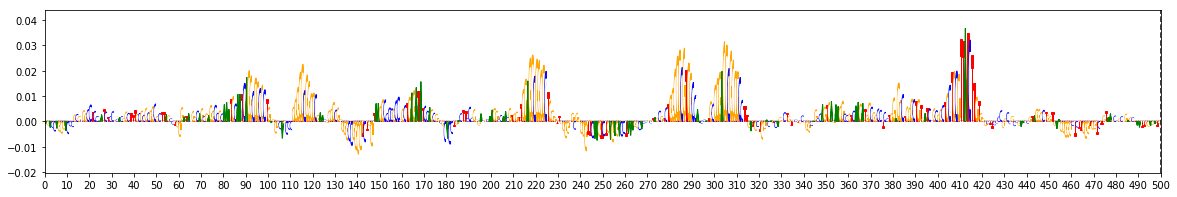

Index:  60  Importance:  1.2052424892600002   chr11 : 33892768 - 33893268


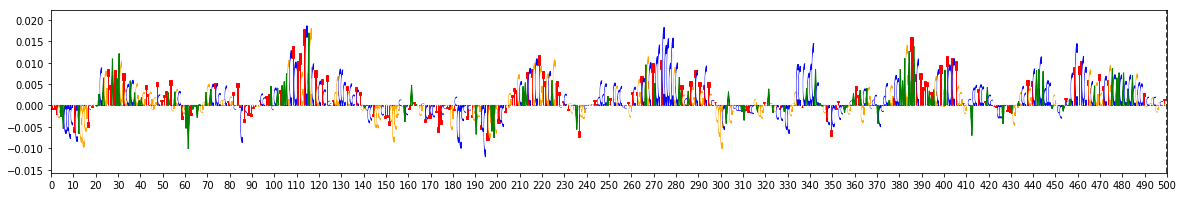

Index:  36  Importance:  1.0542232606000002   chr11 : 33881821 - 33882321


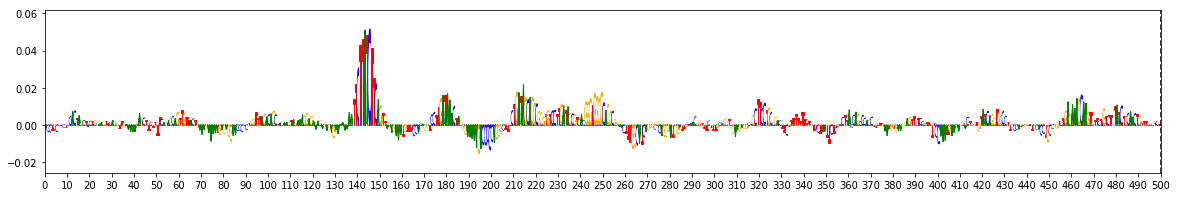

Index:  40  Importance:  0.9079257842799999   chr11 : 33885250 - 33885750


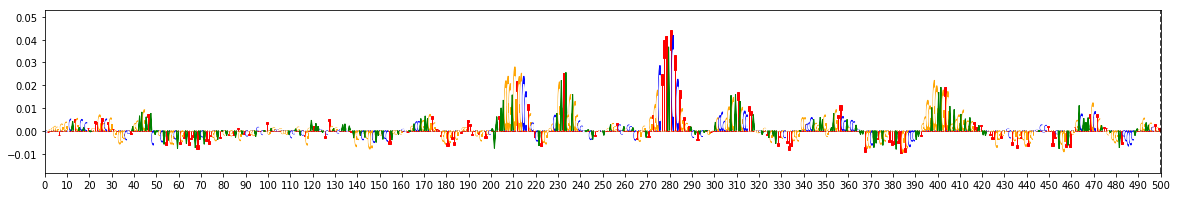

Index:  86  Importance:  0.8525319282899999   chr11 : 34915899 - 34916399


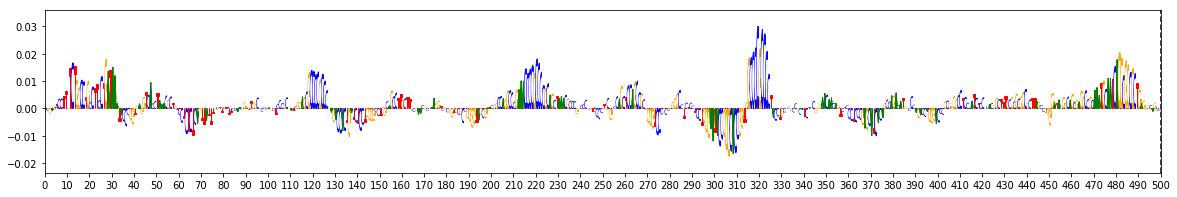

Index:  74  Importance:  0.7081227896   chr11 : 34464445 - 34464945


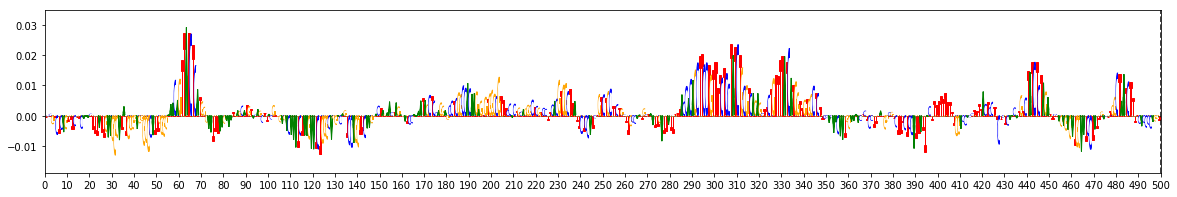

Index:  70  Importance:  0.6876484012999999   chr11 : 34438577 - 34439077


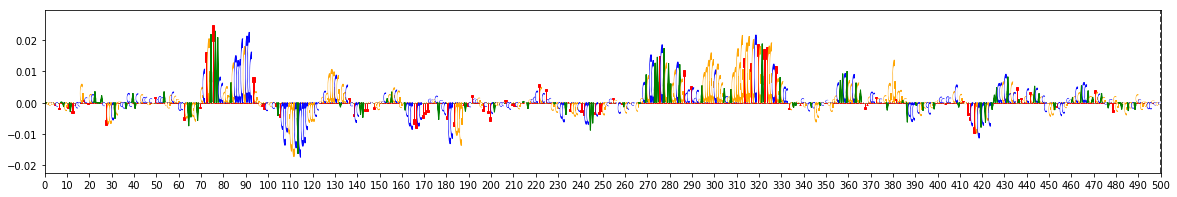

Index:  76  Importance:  0.6271590761599999   chr11 : 34464692 - 34465192


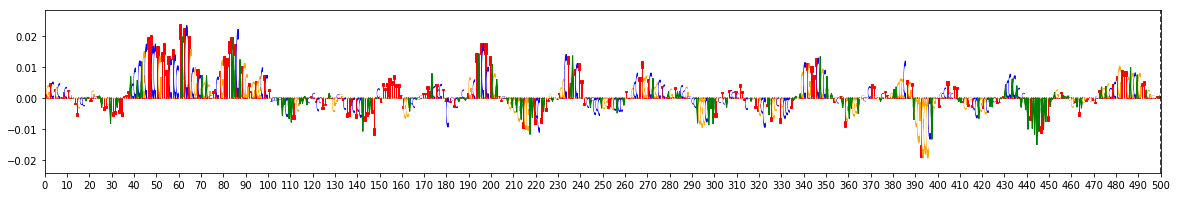

Index:  67  Importance:  0.49553588717   chr11 : 34143058 - 34143558


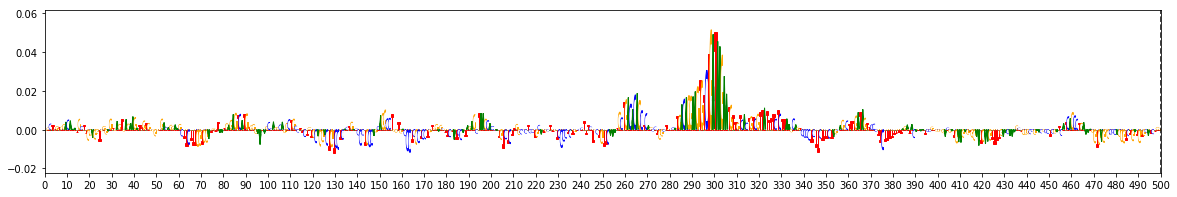

Index:  65  Importance:  0.46912376249999993   chr11 : 34105306 - 34105806


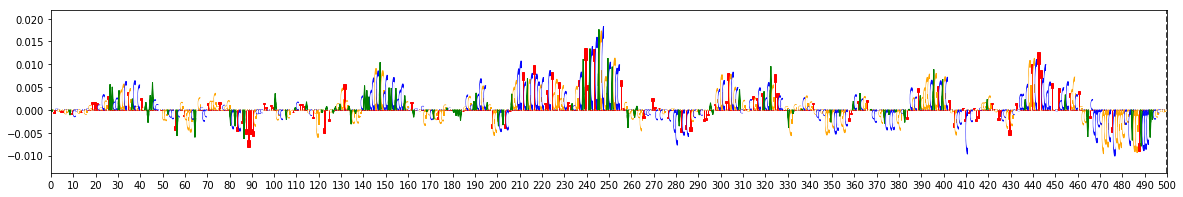

Index:  66  Importance:  0.41590408766   chr11 : 34104971 - 34105471


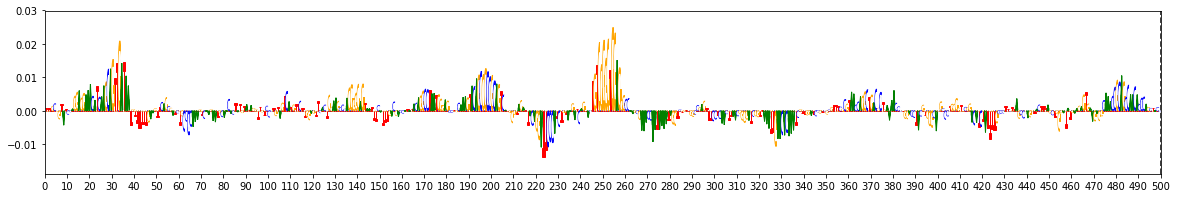

Index:  84  Importance:  0.4076277212299999   chr11 : 34909379 - 34909879


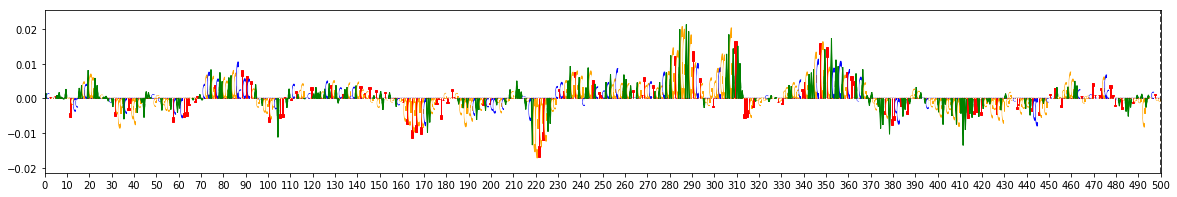

Index:  16  Importance:  0.39454540052   chr11 : 33869651 - 33870151


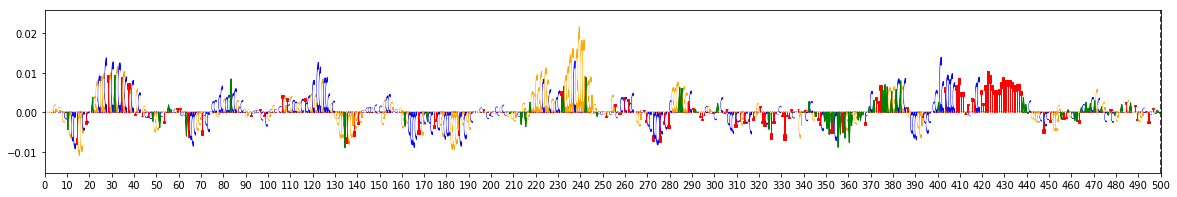

Index:  78  Importance:  0.36610201252999997   chr11 : 34468164 - 34468664


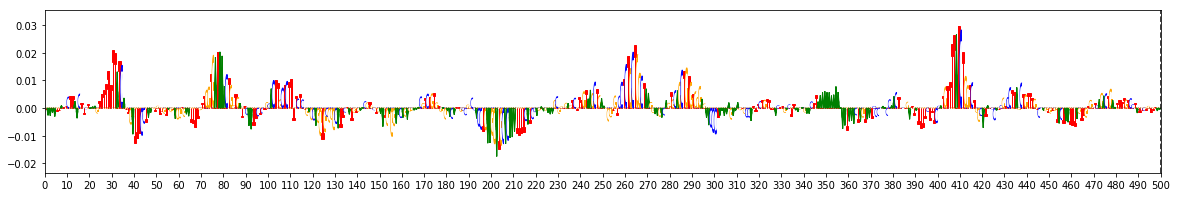

Index:  83  Importance:  0.247140122   chr11 : 34908869 - 34909369


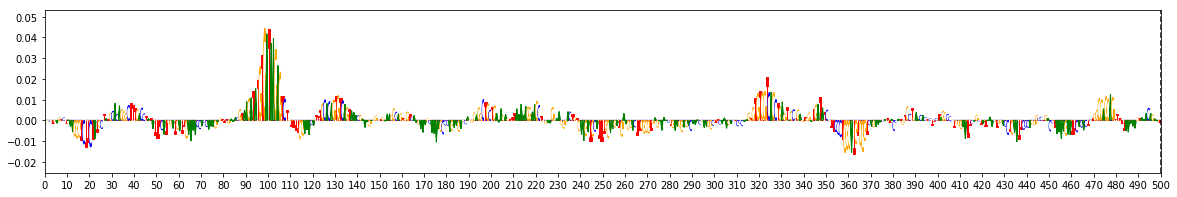

Index:  32  Importance:  -0.007305144999999999   chr11 : 33870655 - 33871155


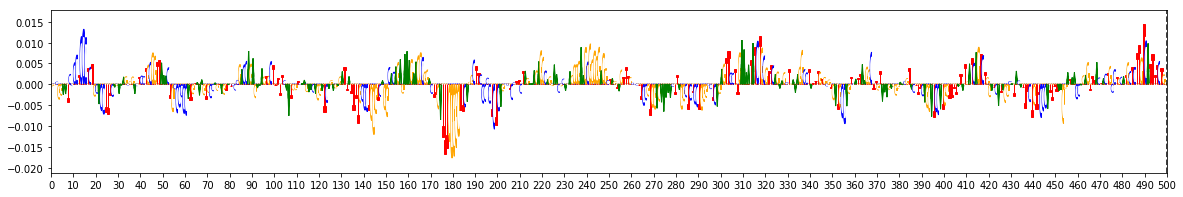

Index:  12  Importance:  -0.11157849139999998   chr11 : 33869934 - 33870434


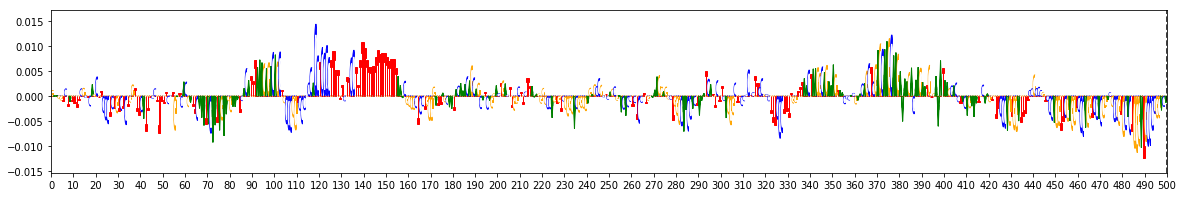

Index:  20  Importance:  -0.15166789523000002   chr11 : 33869341 - 33869841


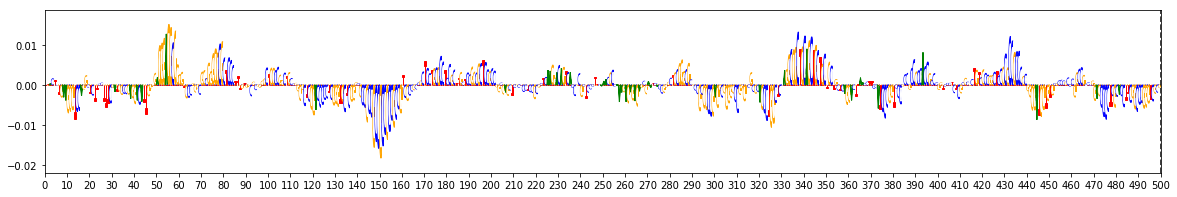

Index:  64  Importance:  -0.1682164356000001   chr11 : 34105726 - 34106226


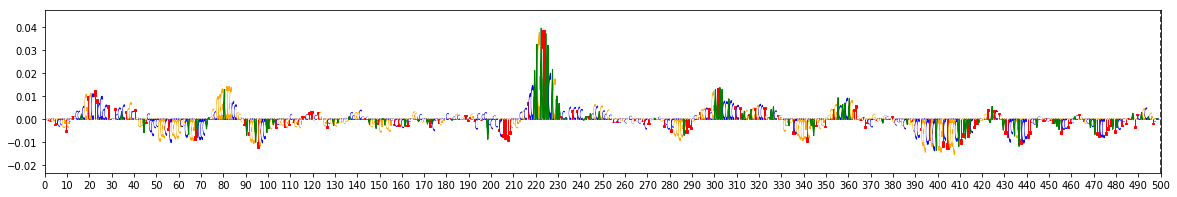

Index:  68  Importance:  -0.2504438144300001   chr11 : 34439100 - 34439600


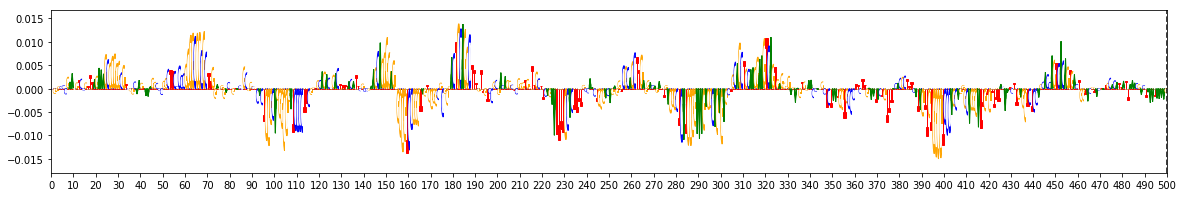

In [6]:
for idx in seq_df.iloc[:20]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'score'], ' ',
          seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'])
    ylim = plot_weights(imp_scores[idx], subticks_frequency=10, xlim=(0,500))

Index:  85  Importance:  1.8854963125800004   chr11 : 34916289 - 34916789


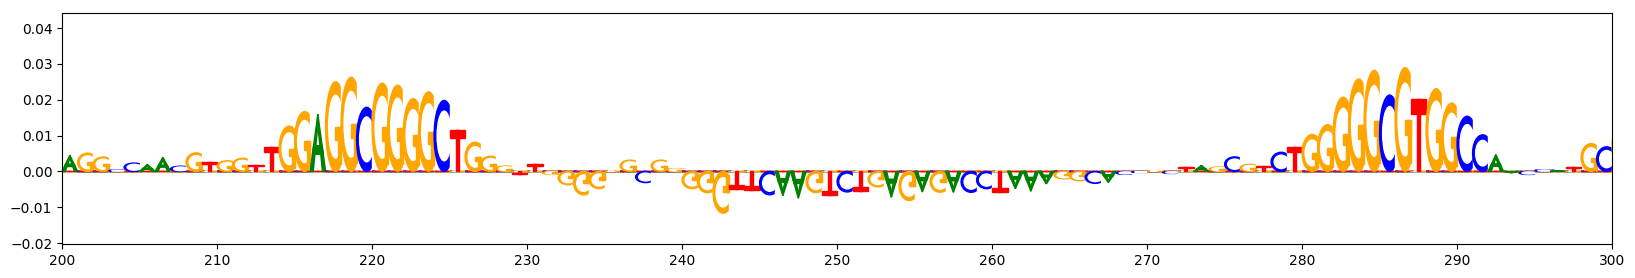

Index:  60  Importance:  1.2052424892600002   chr11 : 33892768 - 33893268


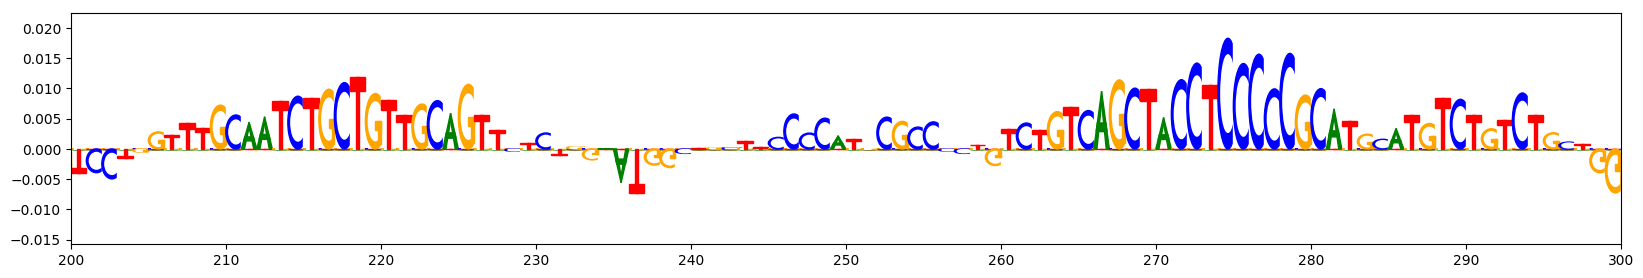

Index:  36  Importance:  1.0542232606000002   chr11 : 33881821 - 33882321


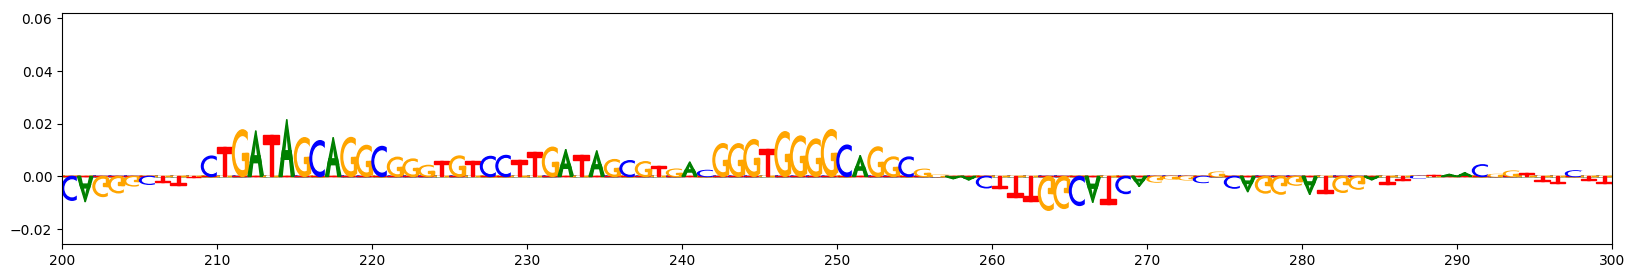

Index:  40  Importance:  0.9079257842799999   chr11 : 33885250 - 33885750


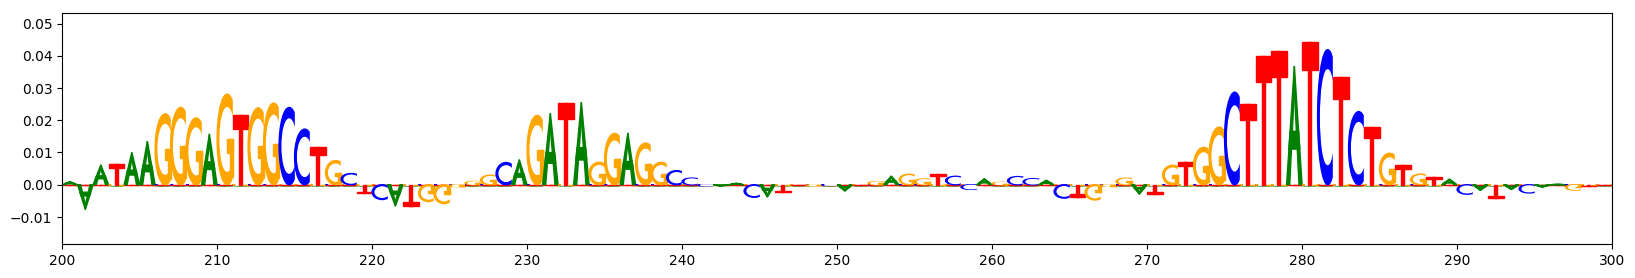

Index:  86  Importance:  0.8525319282899999   chr11 : 34915899 - 34916399


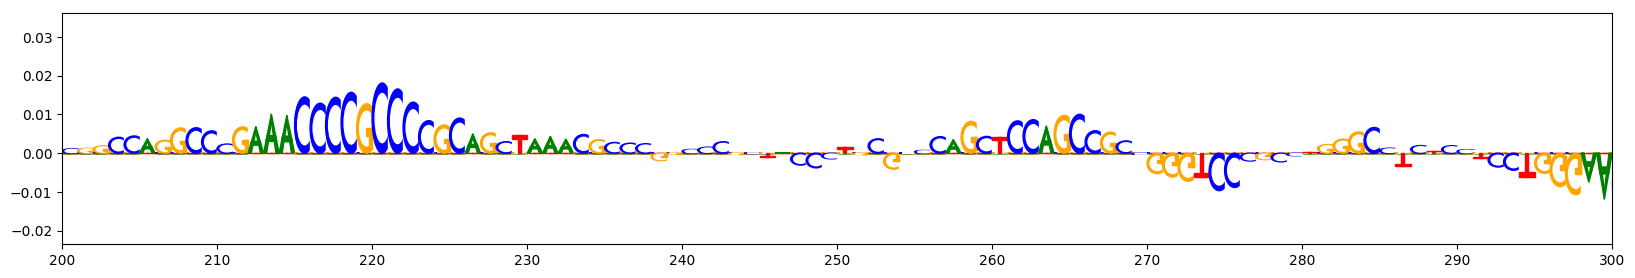

Index:  74  Importance:  0.7081227896   chr11 : 34464445 - 34464945


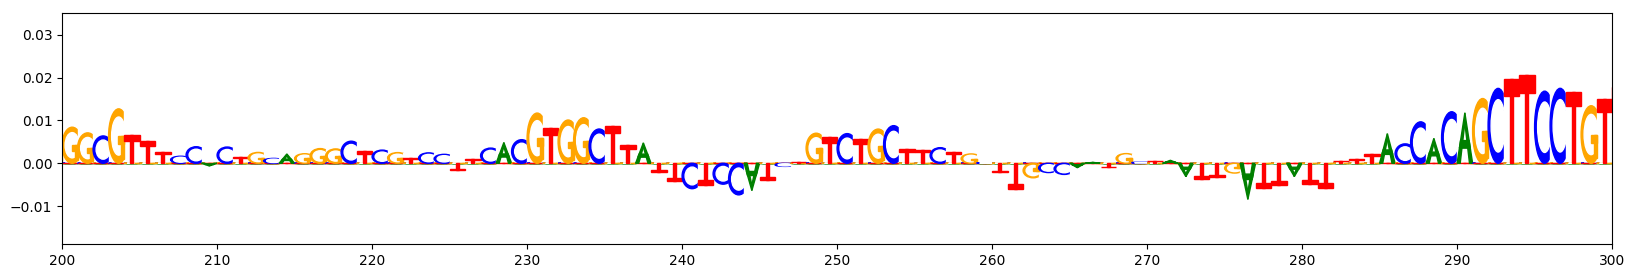

Index:  70  Importance:  0.6876484012999999   chr11 : 34438577 - 34439077


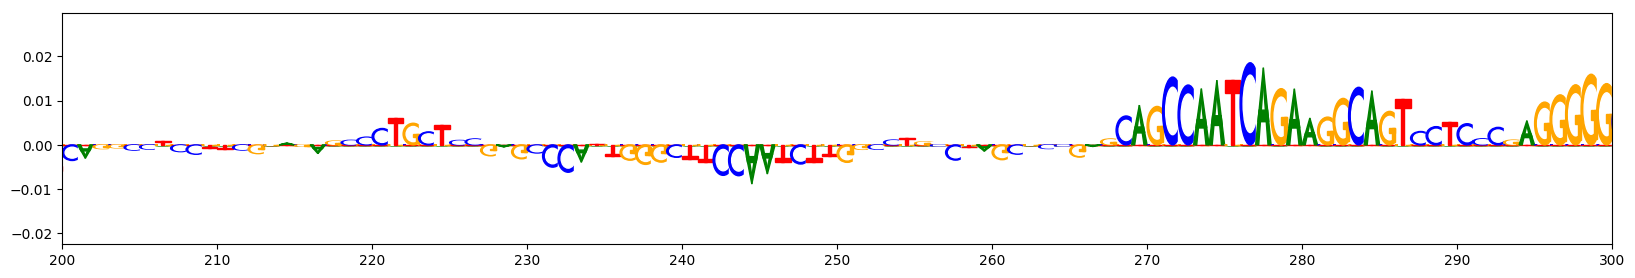

Index:  76  Importance:  0.6271590761599999   chr11 : 34464692 - 34465192


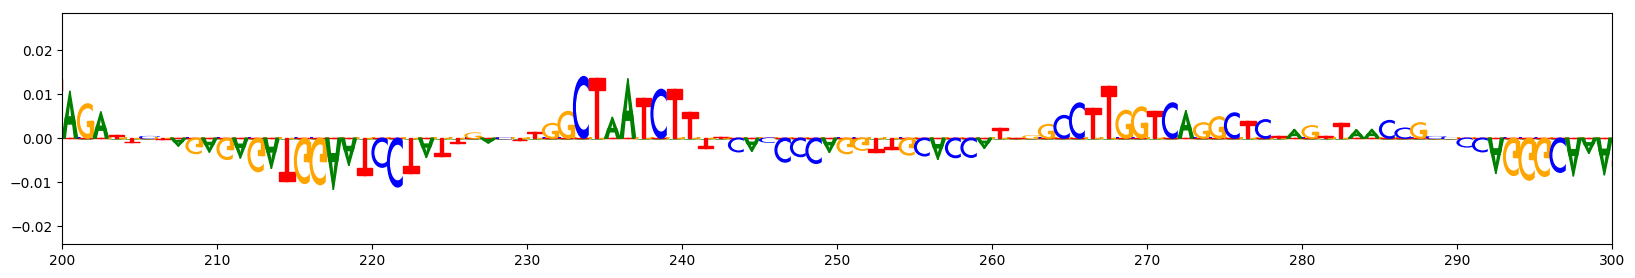

Index:  67  Importance:  0.49553588717   chr11 : 34143058 - 34143558


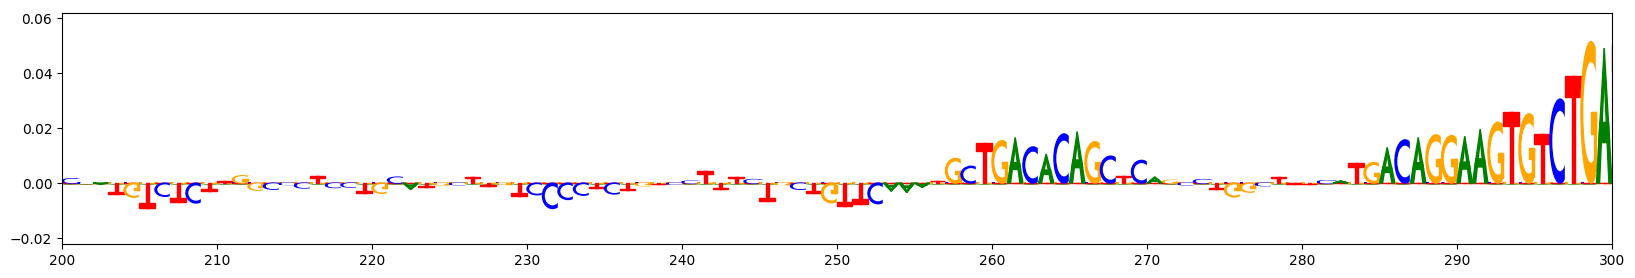

Index:  65  Importance:  0.46912376249999993   chr11 : 34105306 - 34105806


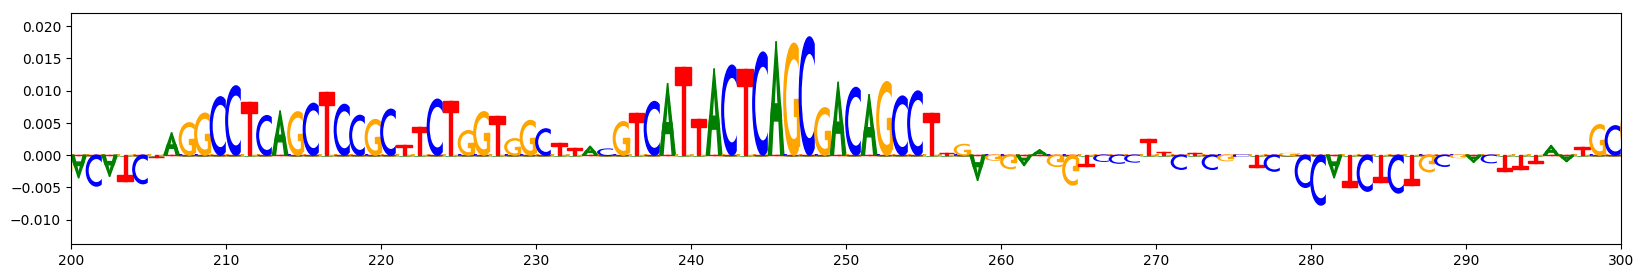

Index:  66  Importance:  0.41590408766   chr11 : 34104971 - 34105471


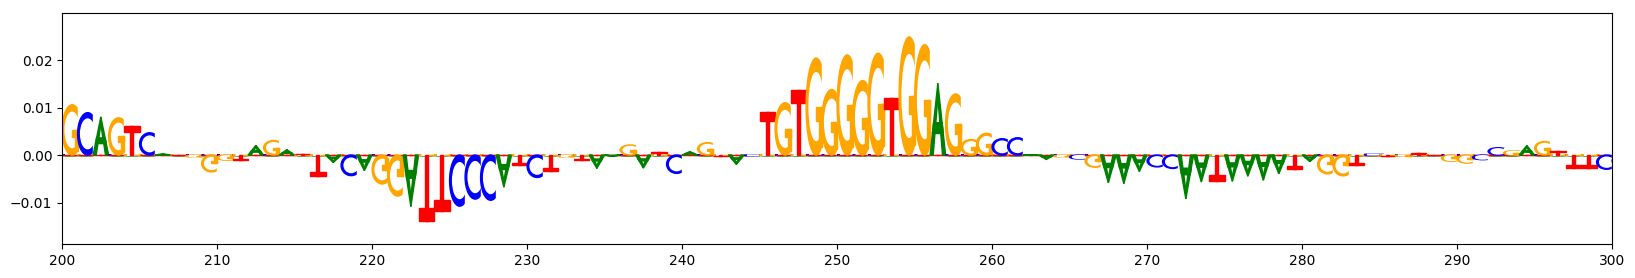

Index:  84  Importance:  0.4076277212299999   chr11 : 34909379 - 34909879


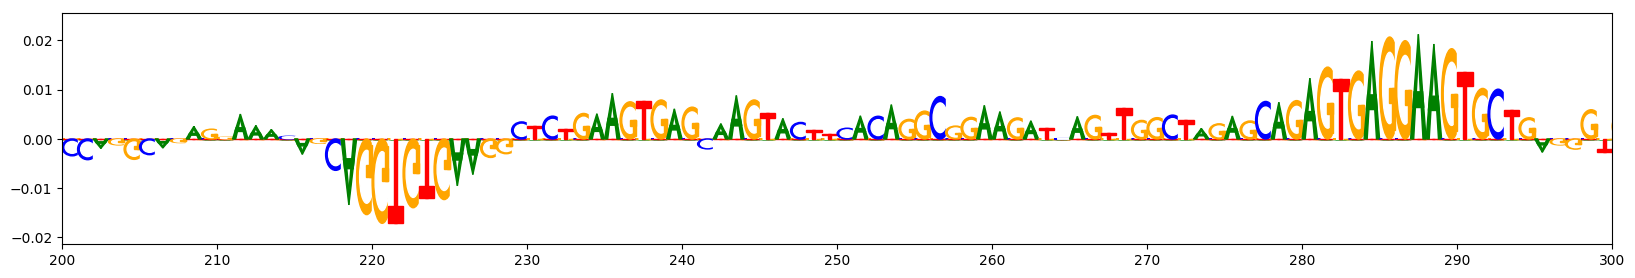

Index:  16  Importance:  0.39454540052   chr11 : 33869651 - 33870151


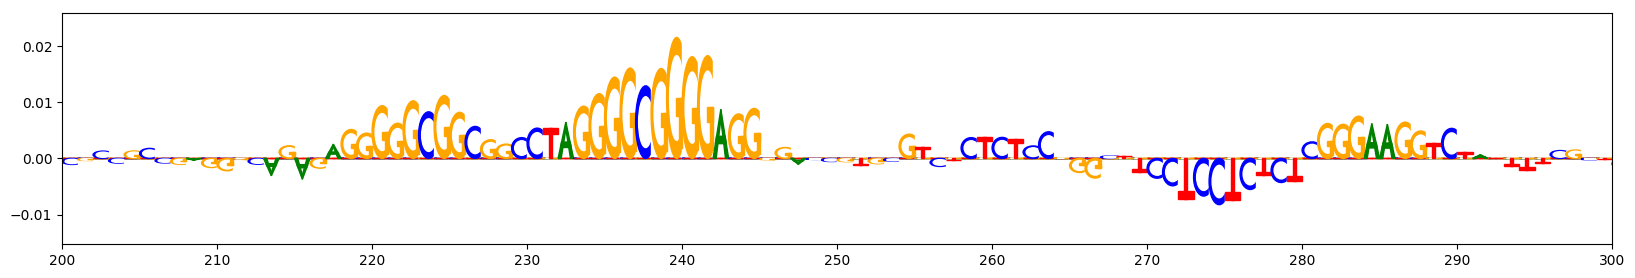

Index:  78  Importance:  0.36610201252999997   chr11 : 34468164 - 34468664


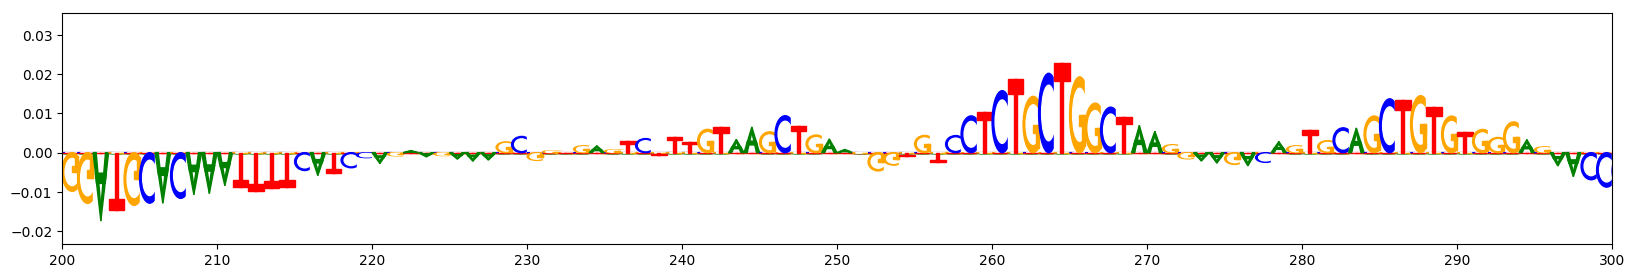

Index:  83  Importance:  0.247140122   chr11 : 34908869 - 34909369


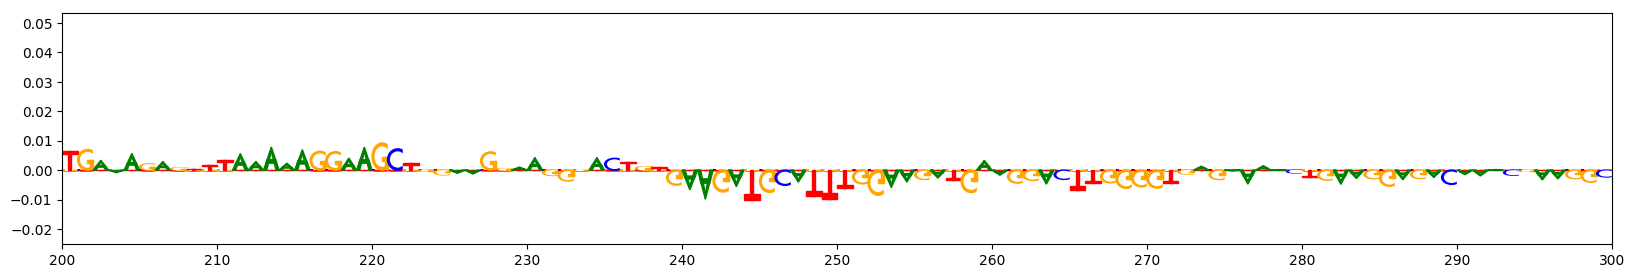

Index:  32  Importance:  -0.007305144999999999   chr11 : 33870655 - 33871155


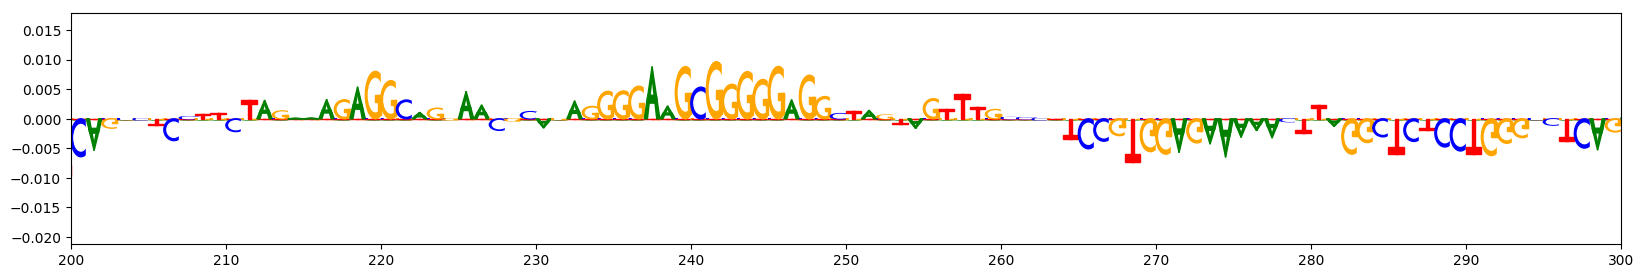

Index:  12  Importance:  -0.11157849139999998   chr11 : 33869934 - 33870434


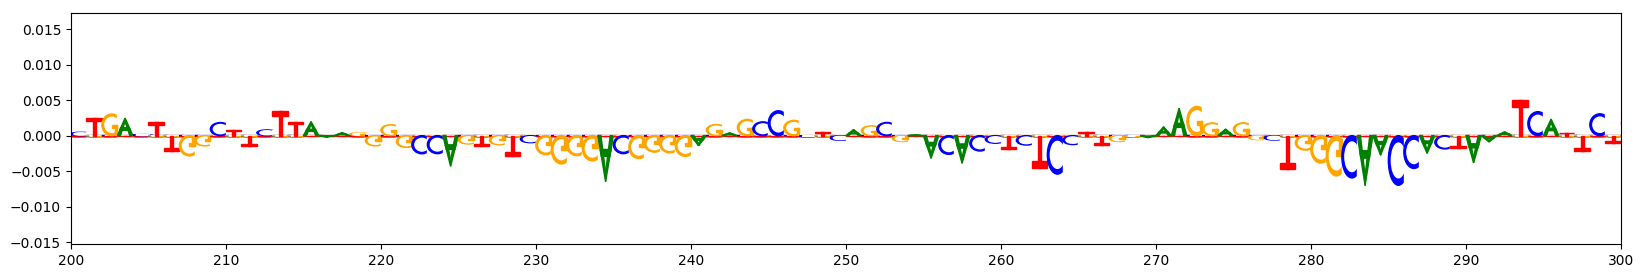

Index:  20  Importance:  -0.15166789523000002   chr11 : 33869341 - 33869841


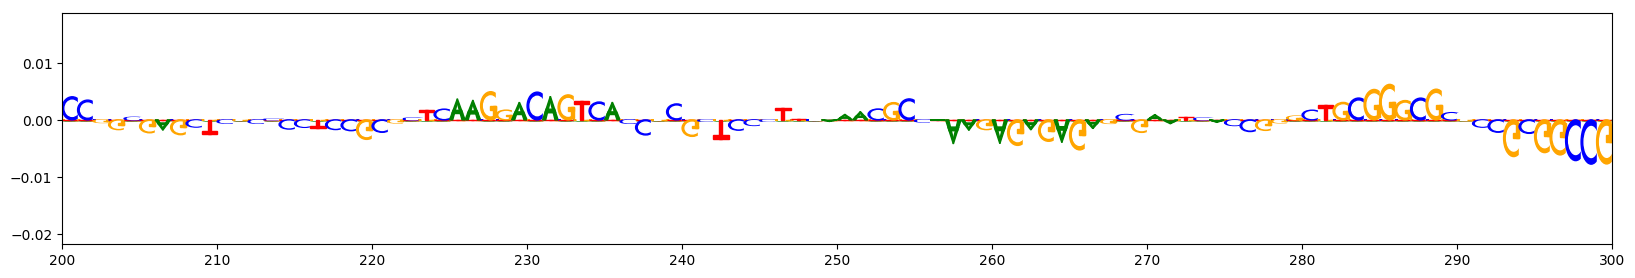

Index:  64  Importance:  -0.1682164356000001   chr11 : 34105726 - 34106226


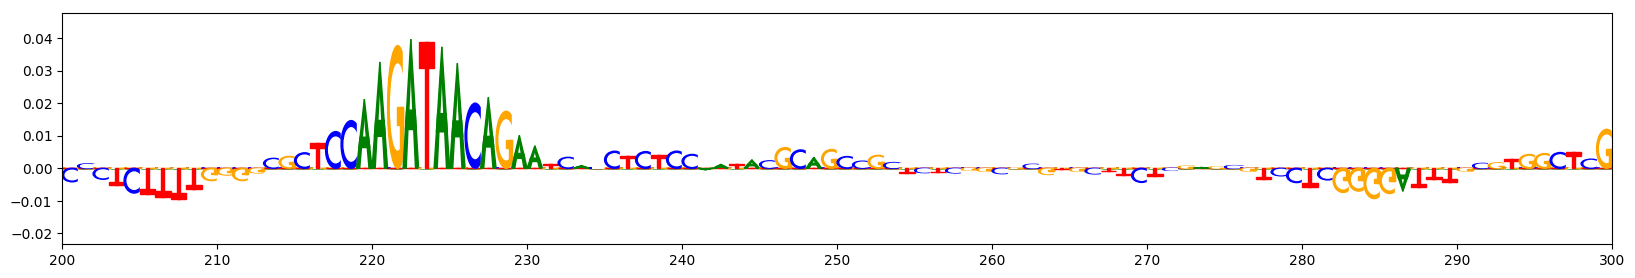

Index:  68  Importance:  -0.2504438144300001   chr11 : 34439100 - 34439600


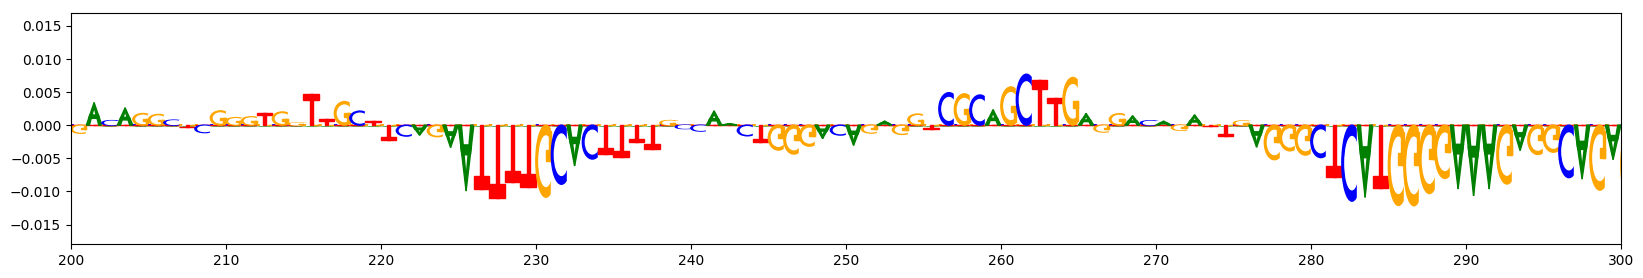

In [6]:
for idx in seq_df.iloc[:20]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'score'], ' ',
          seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'])
    ylim = plot_weights(imp_scores[idx], subticks_frequency=10, xlim=(200,300))

Index:  85  Importance:  1.8854963125800004   chr11 : 34916289 - 34916789


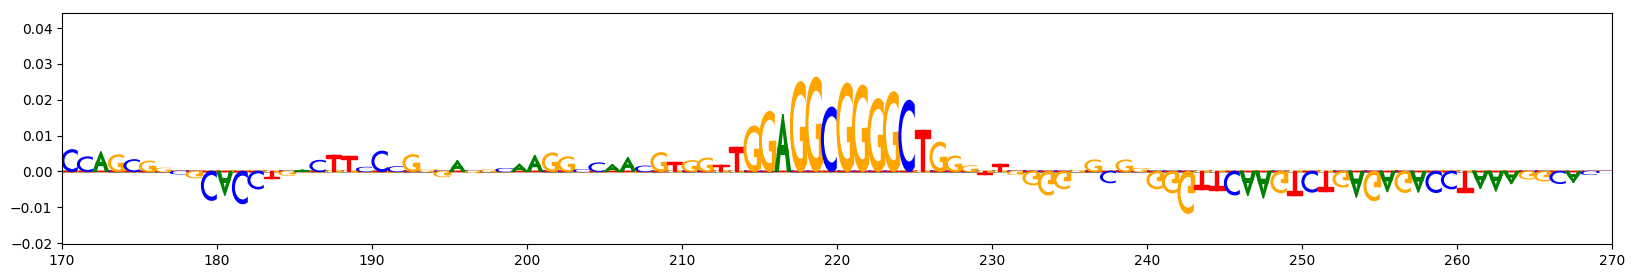

Index:  60  Importance:  1.2052424892600002   chr11 : 33892768 - 33893268


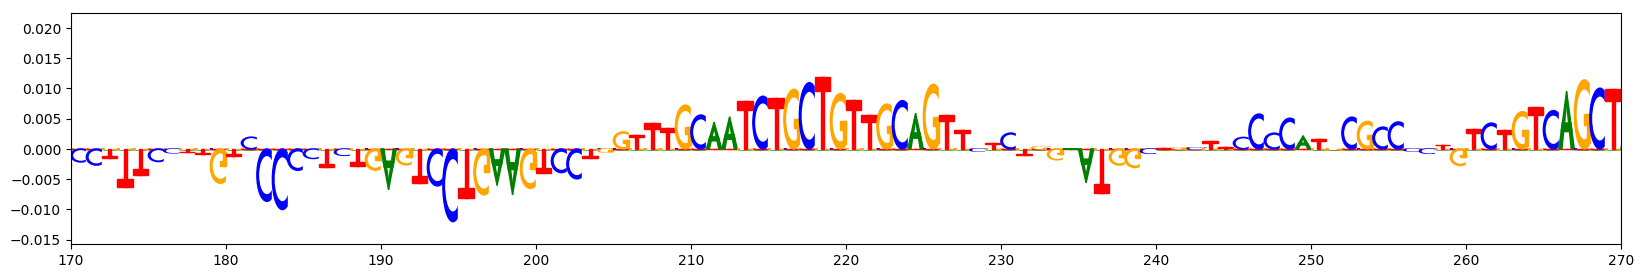

Index:  36  Importance:  1.0542232606000002   chr11 : 33881821 - 33882321


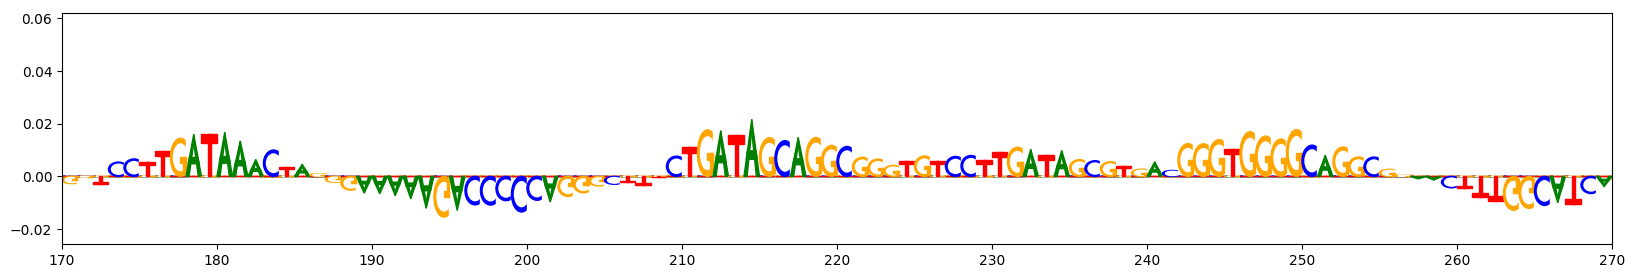

Index:  40  Importance:  0.9079257842799999   chr11 : 33885250 - 33885750


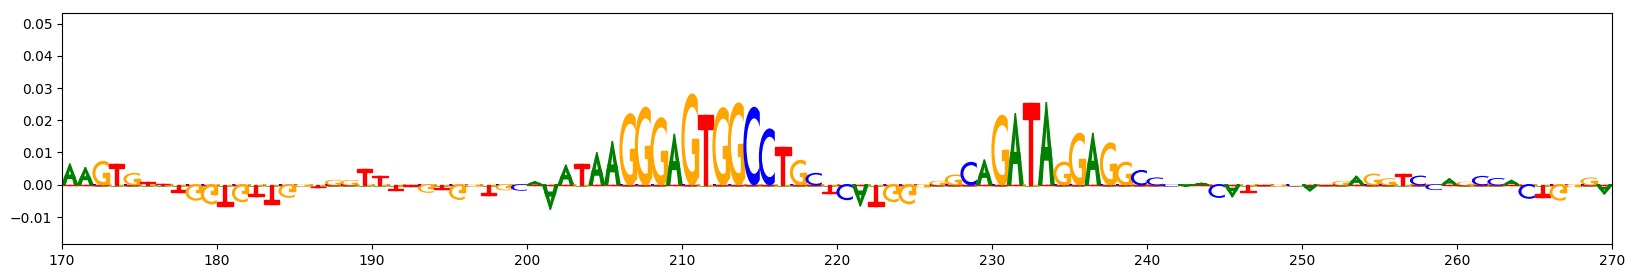

Index:  86  Importance:  0.8525319282899999   chr11 : 34915899 - 34916399


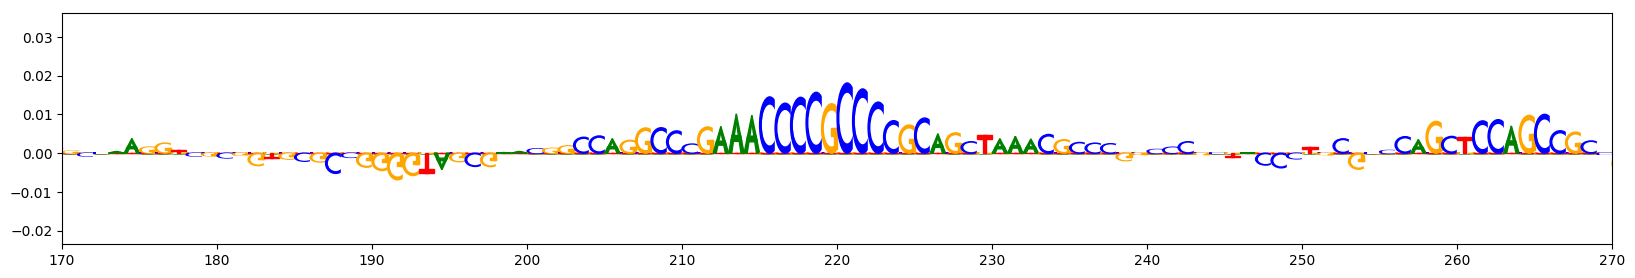

Index:  74  Importance:  0.7081227896   chr11 : 34464445 - 34464945


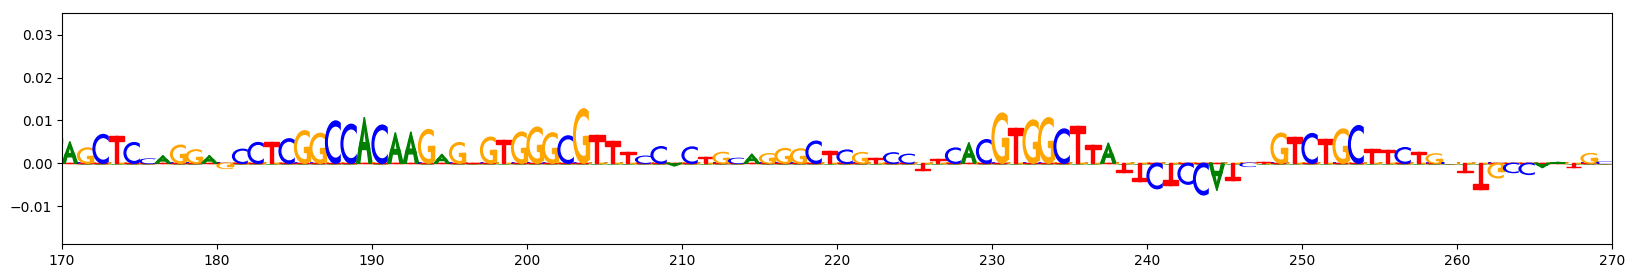

Index:  70  Importance:  0.6876484012999999   chr11 : 34438577 - 34439077


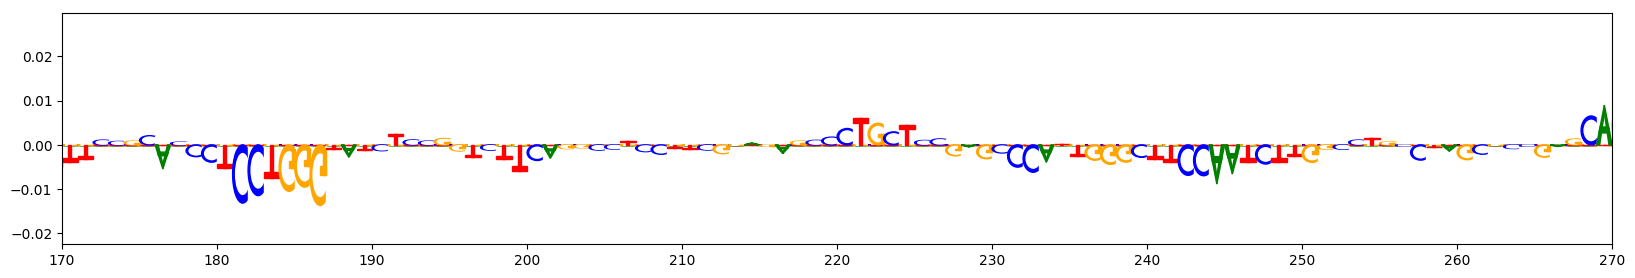

Index:  76  Importance:  0.6271590761599999   chr11 : 34464692 - 34465192


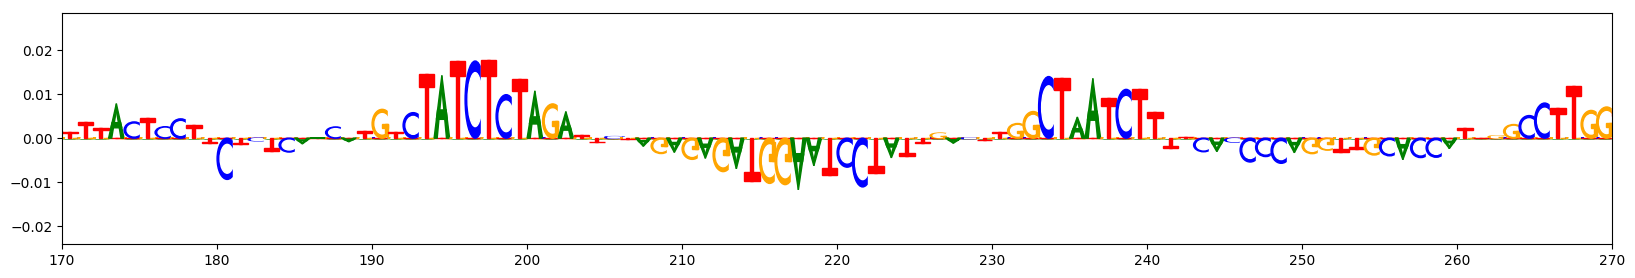

Index:  67  Importance:  0.49553588717   chr11 : 34143058 - 34143558


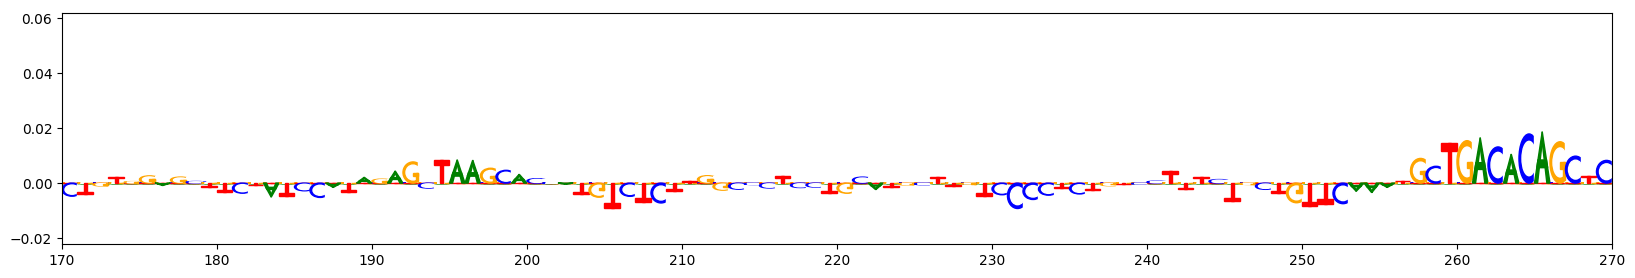

Index:  65  Importance:  0.46912376249999993   chr11 : 34105306 - 34105806


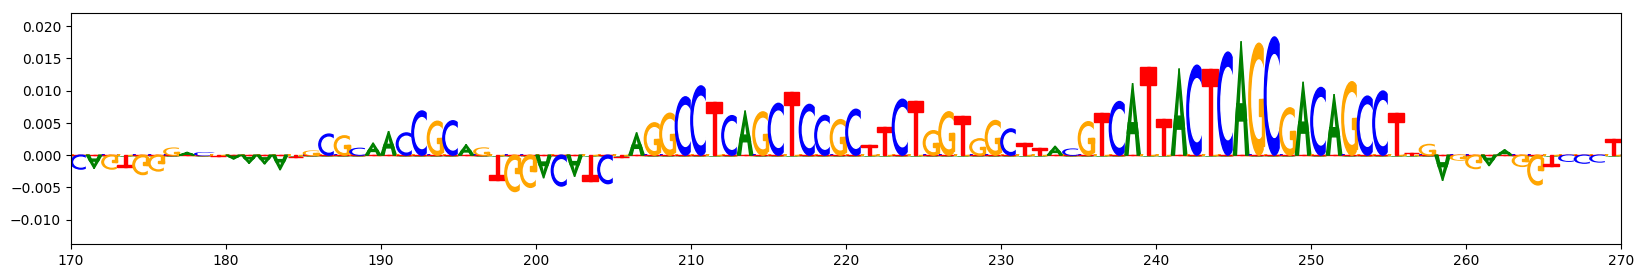

Index:  66  Importance:  0.41590408766   chr11 : 34104971 - 34105471


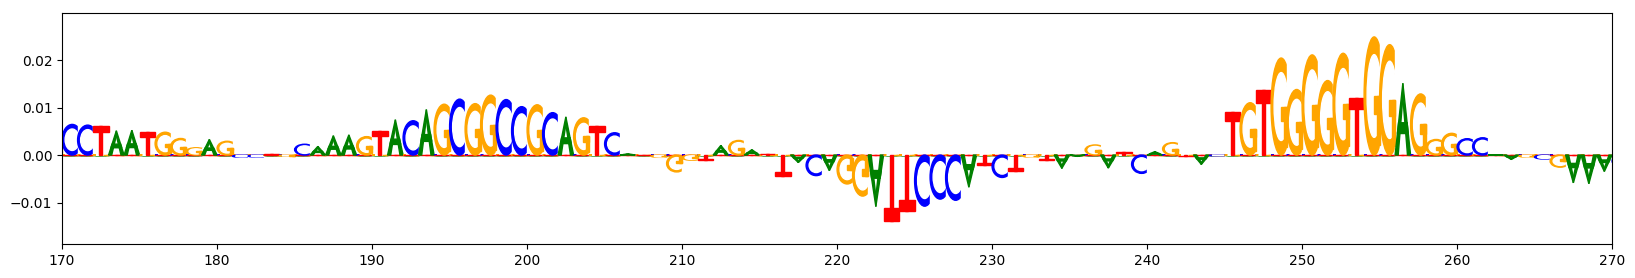

Index:  84  Importance:  0.4076277212299999   chr11 : 34909379 - 34909879


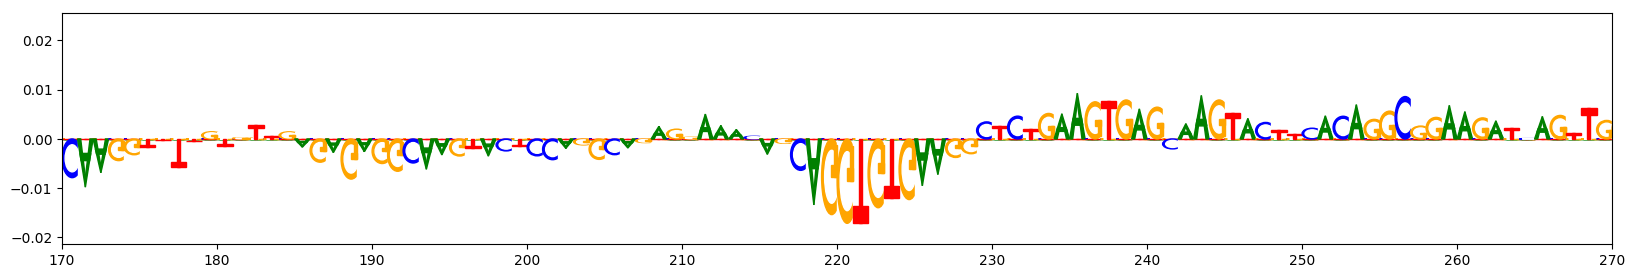

Index:  16  Importance:  0.39454540052   chr11 : 33869651 - 33870151


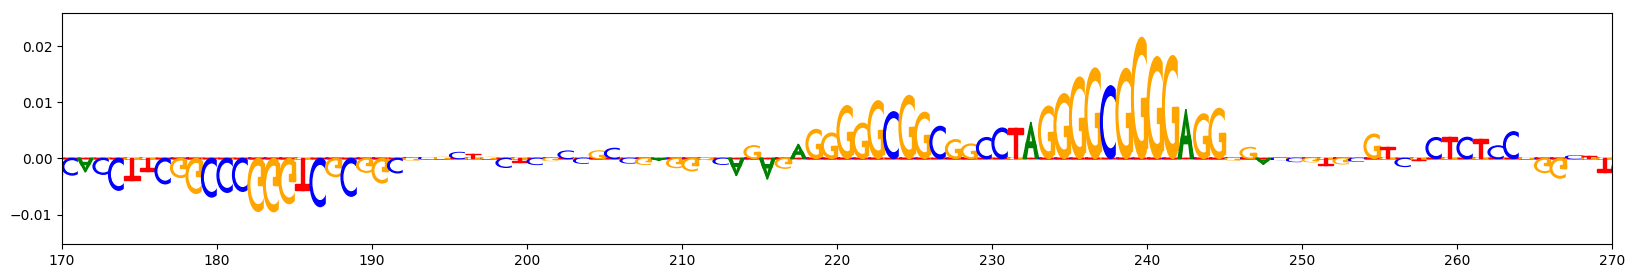

Index:  78  Importance:  0.36610201252999997   chr11 : 34468164 - 34468664


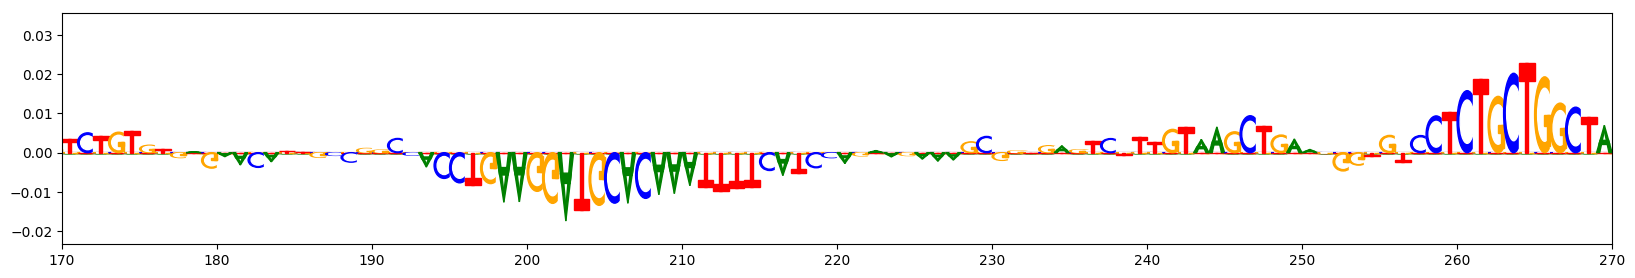

Index:  83  Importance:  0.247140122   chr11 : 34908869 - 34909369


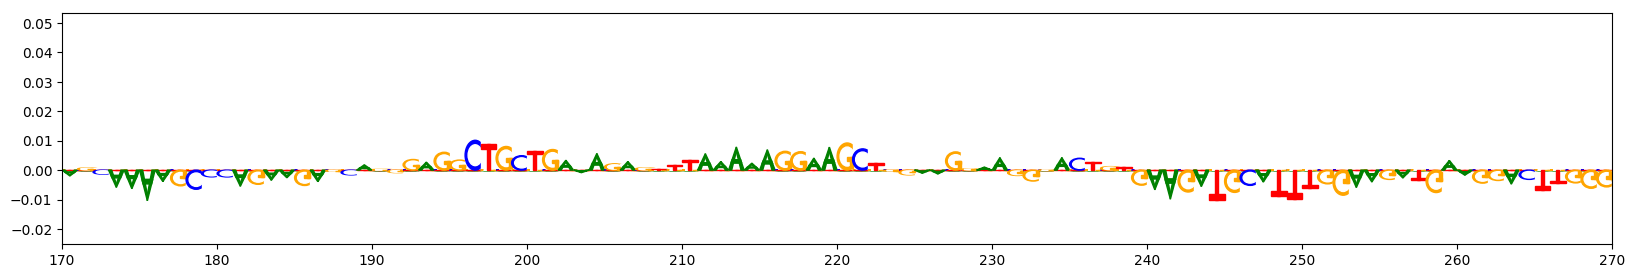

Index:  32  Importance:  -0.007305144999999999   chr11 : 33870655 - 33871155


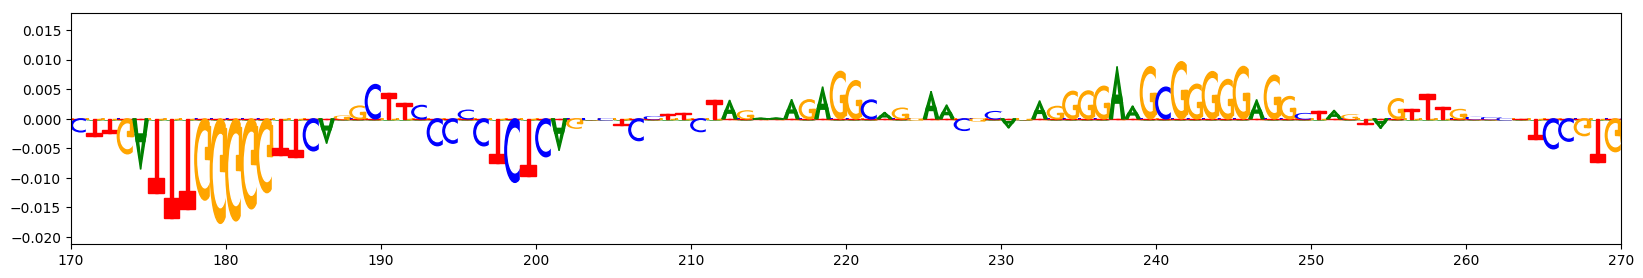

Index:  12  Importance:  -0.11157849139999998   chr11 : 33869934 - 33870434


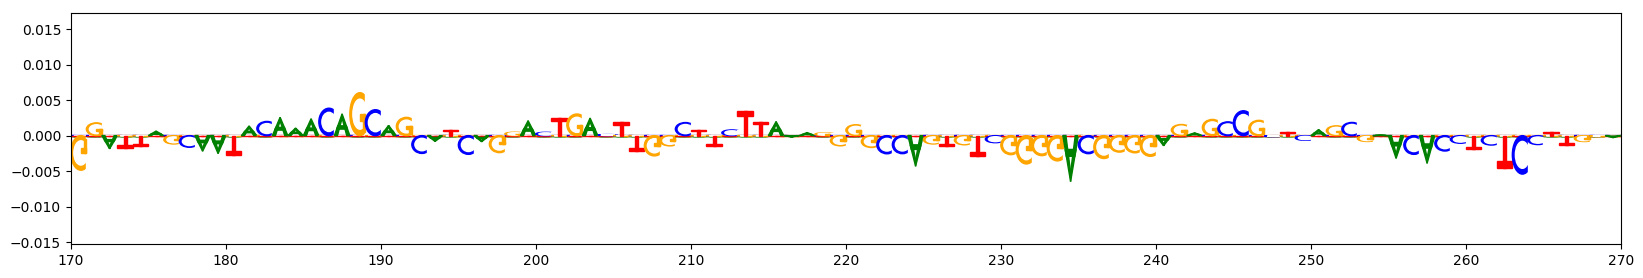

Index:  20  Importance:  -0.15166789523000002   chr11 : 33869341 - 33869841


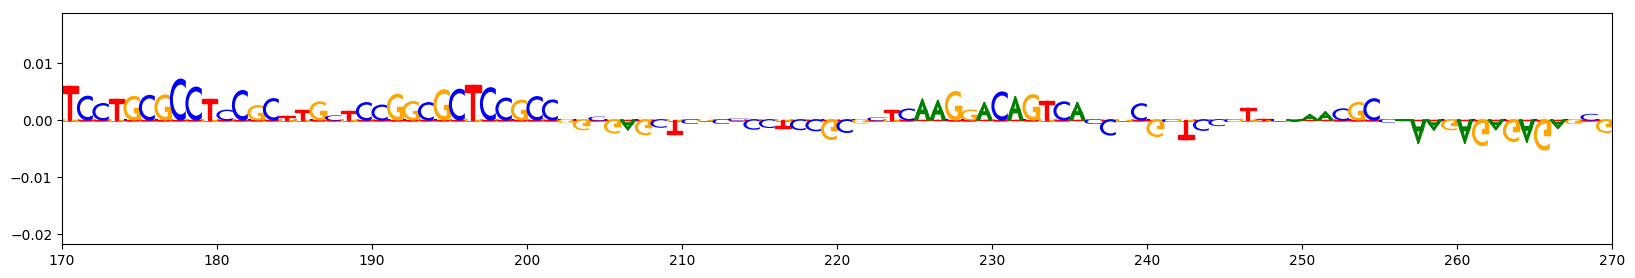

Index:  64  Importance:  -0.1682164356000001   chr11 : 34105726 - 34106226


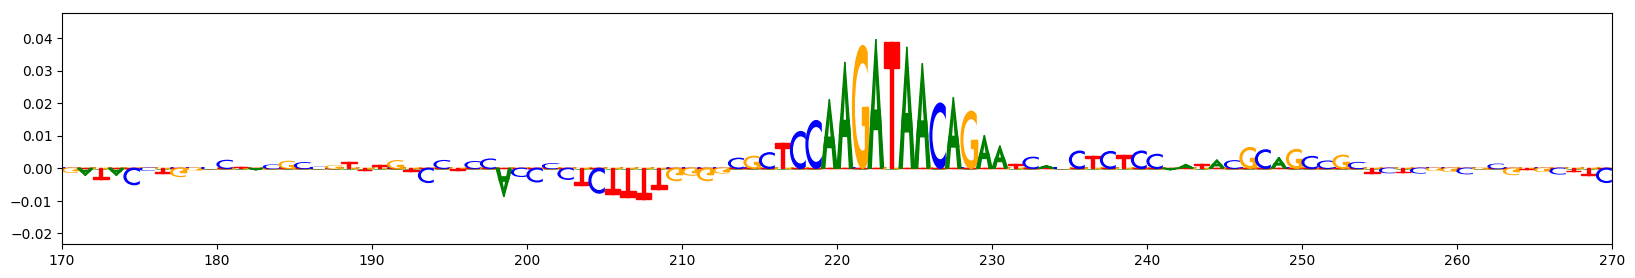

Index:  68  Importance:  -0.2504438144300001   chr11 : 34439100 - 34439600


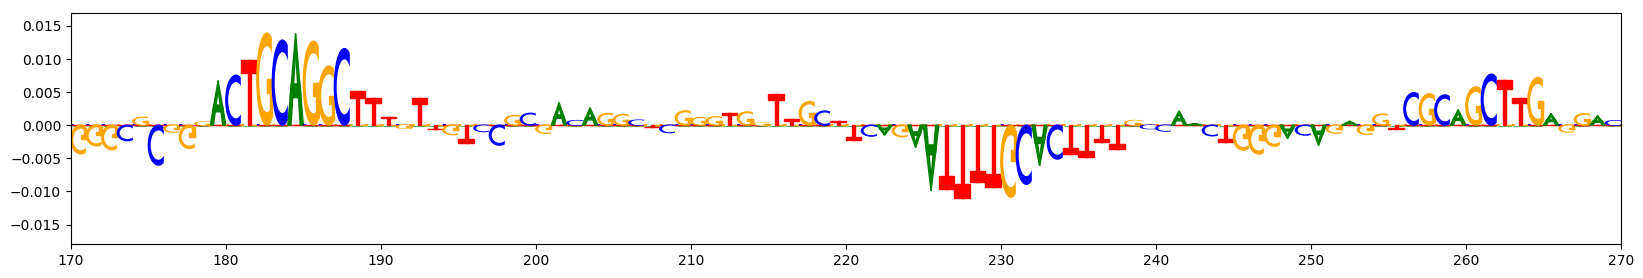

In [7]:
for idx in seq_df.iloc[:20]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'score'], ' ',
          seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'])
    ylim = plot_weights(imp_scores[idx], subticks_frequency=10, xlim=(170,270))

Index:  85  Importance:  1.8854963125800004   chr11 : 34916289 - 34916789


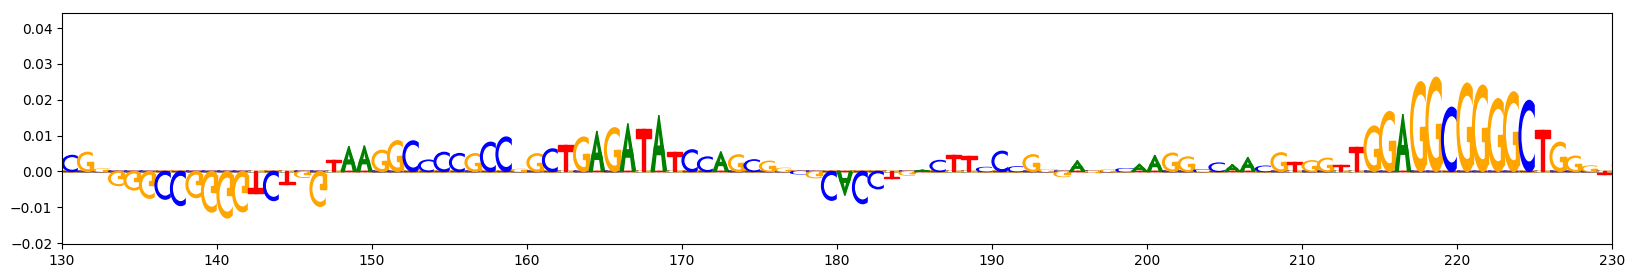

Index:  60  Importance:  1.2052424892600002   chr11 : 33892768 - 33893268


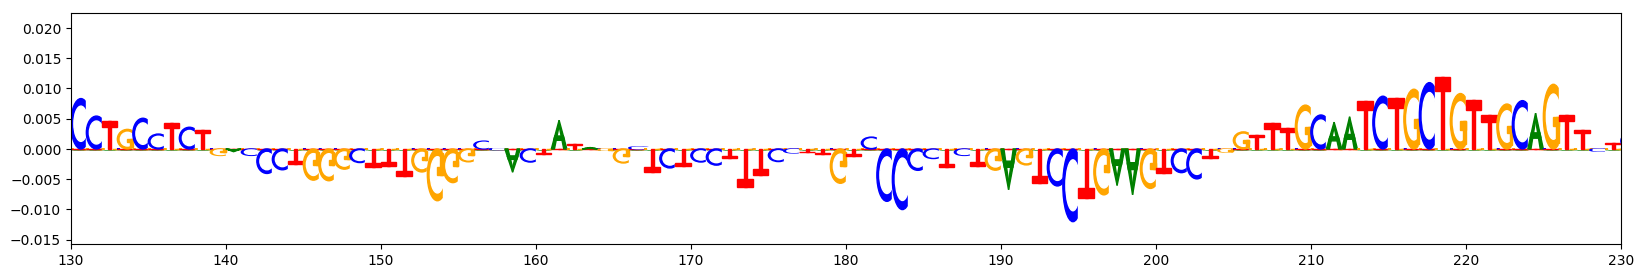

Index:  36  Importance:  1.0542232606000002   chr11 : 33881821 - 33882321


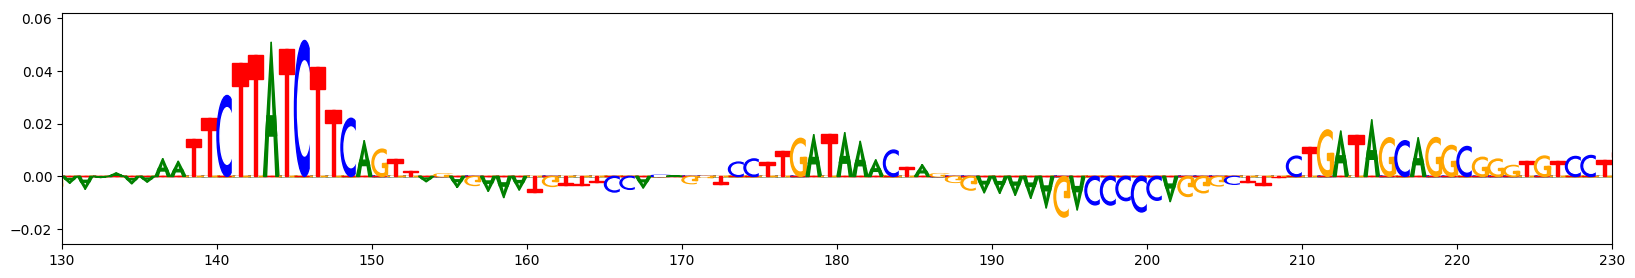

Index:  40  Importance:  0.9079257842799999   chr11 : 33885250 - 33885750


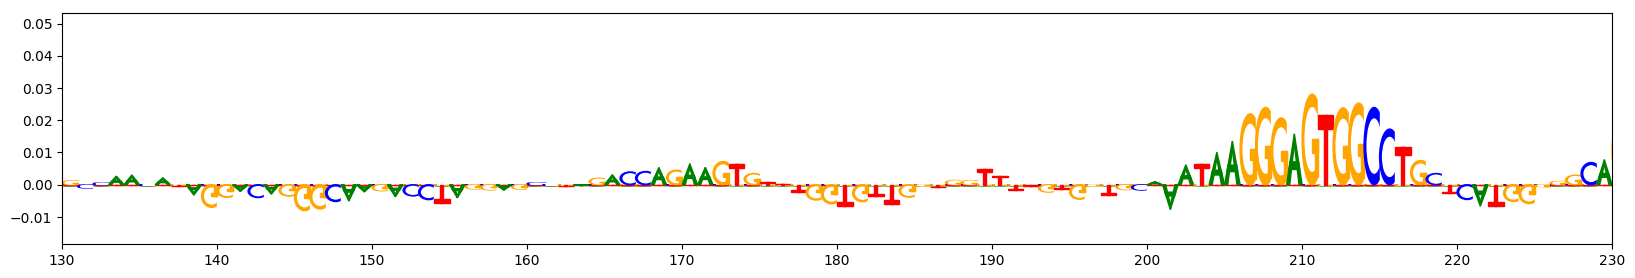

Index:  86  Importance:  0.8525319282899999   chr11 : 34915899 - 34916399


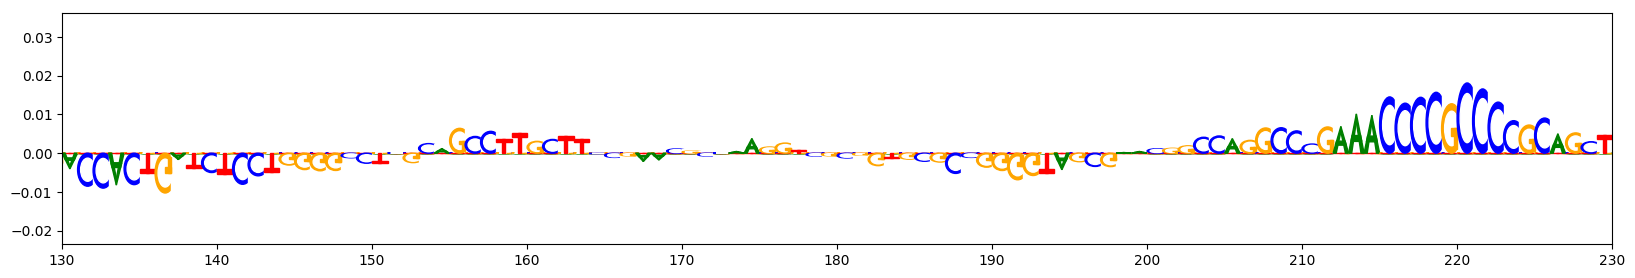

Index:  74  Importance:  0.7081227896   chr11 : 34464445 - 34464945


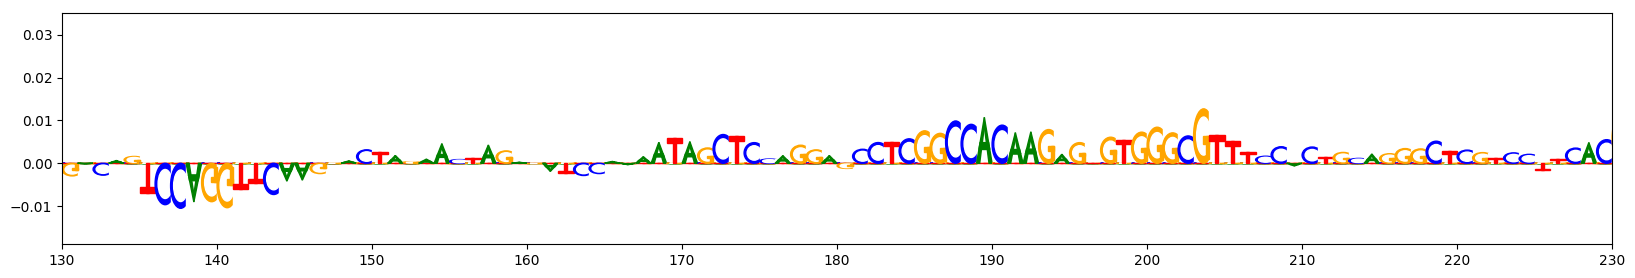

Index:  70  Importance:  0.6876484012999999   chr11 : 34438577 - 34439077


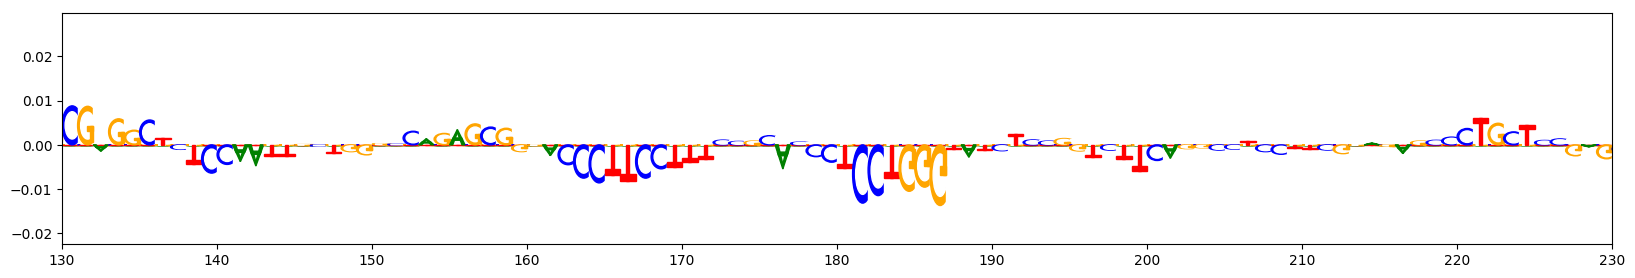

Index:  76  Importance:  0.6271590761599999   chr11 : 34464692 - 34465192


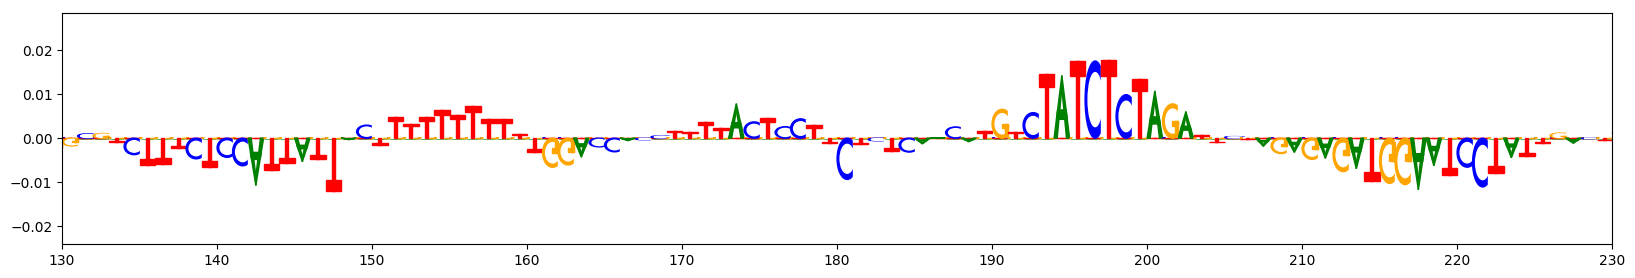

Index:  67  Importance:  0.49553588717   chr11 : 34143058 - 34143558


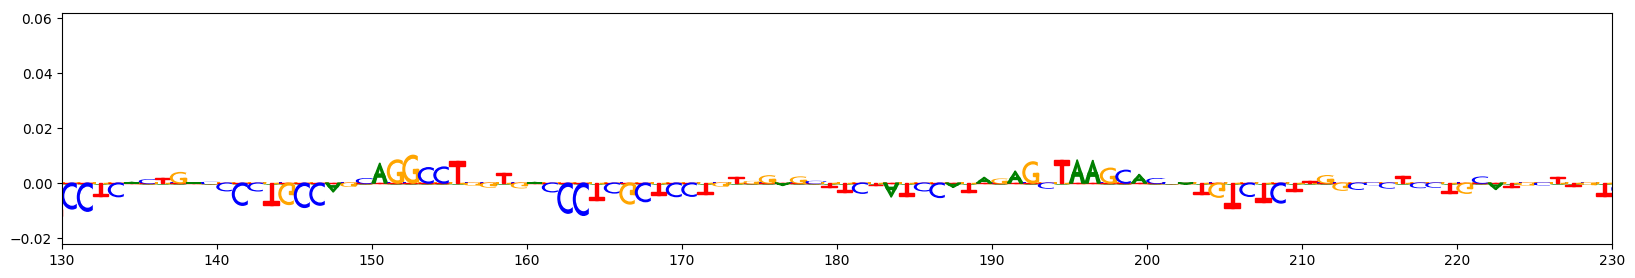

Index:  65  Importance:  0.46912376249999993   chr11 : 34105306 - 34105806


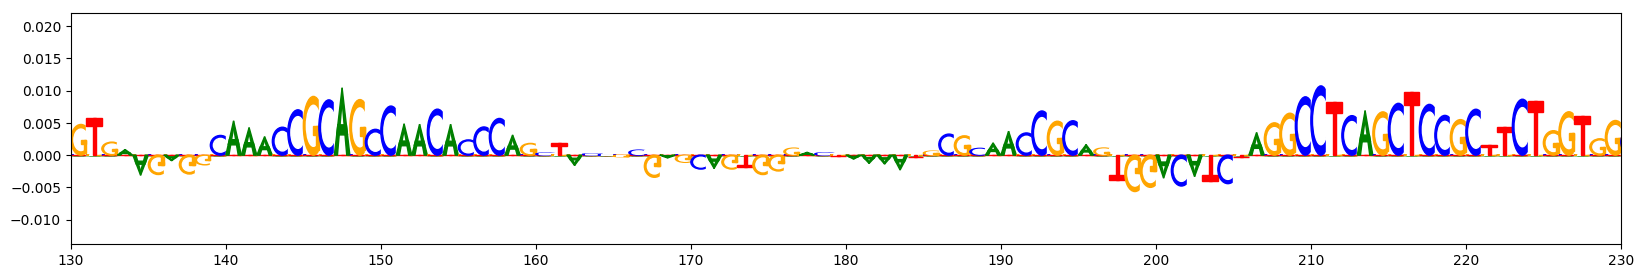

Index:  66  Importance:  0.41590408766   chr11 : 34104971 - 34105471


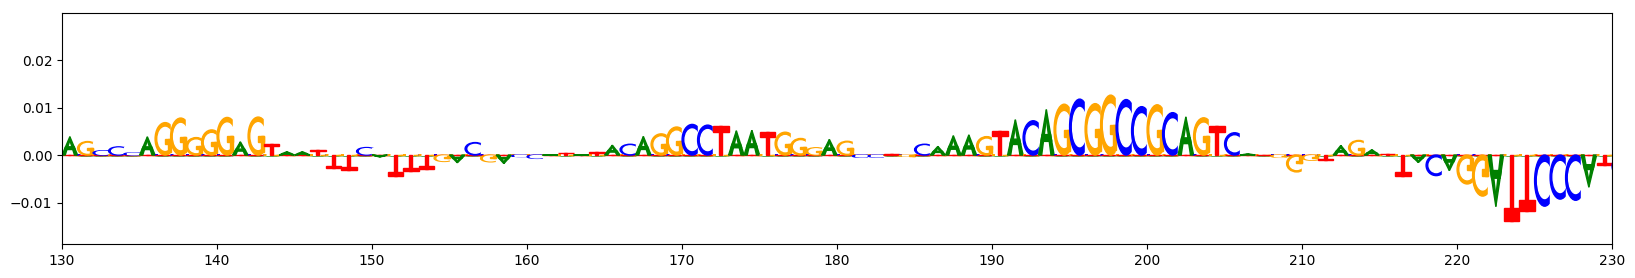

Index:  84  Importance:  0.4076277212299999   chr11 : 34909379 - 34909879


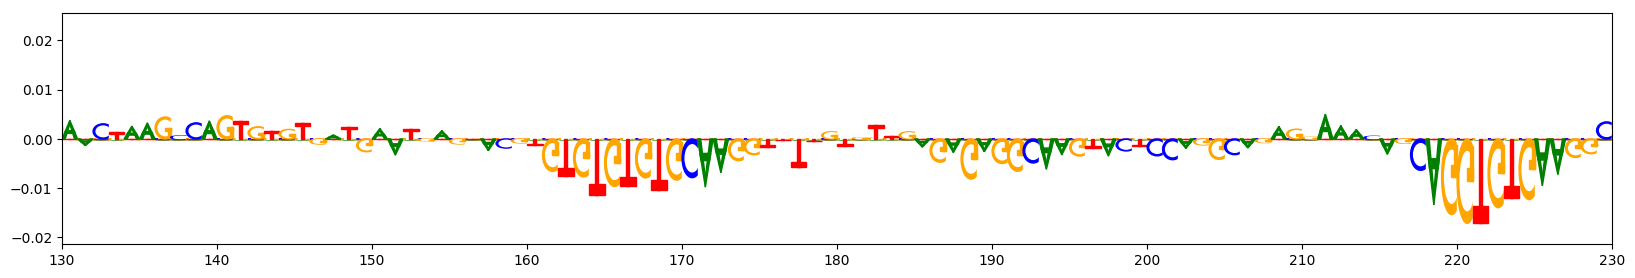

Index:  16  Importance:  0.39454540052   chr11 : 33869651 - 33870151


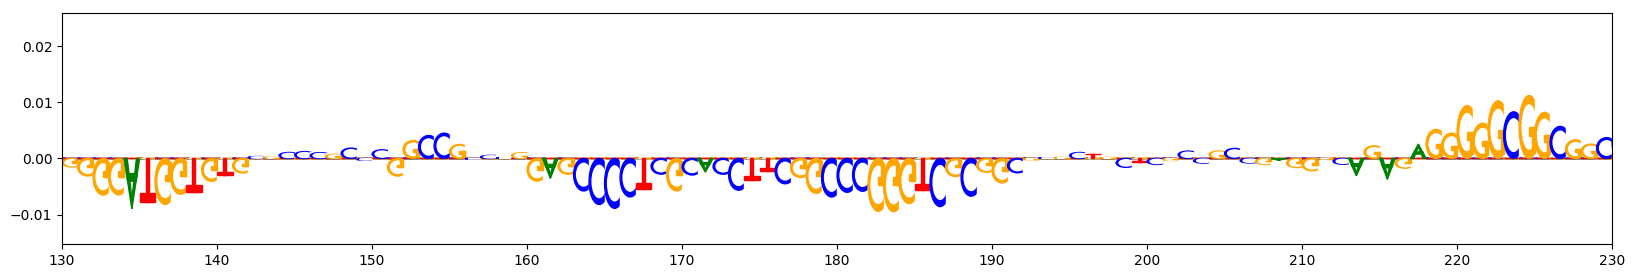

Index:  78  Importance:  0.36610201252999997   chr11 : 34468164 - 34468664


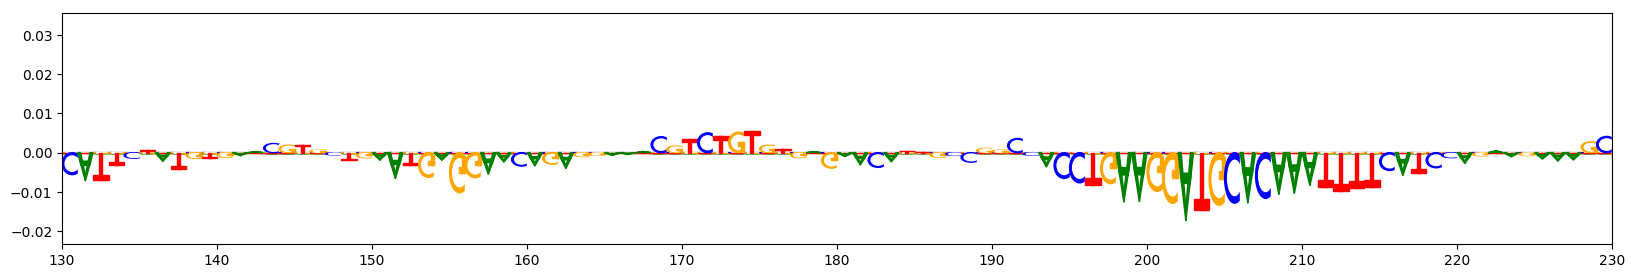

Index:  83  Importance:  0.247140122   chr11 : 34908869 - 34909369


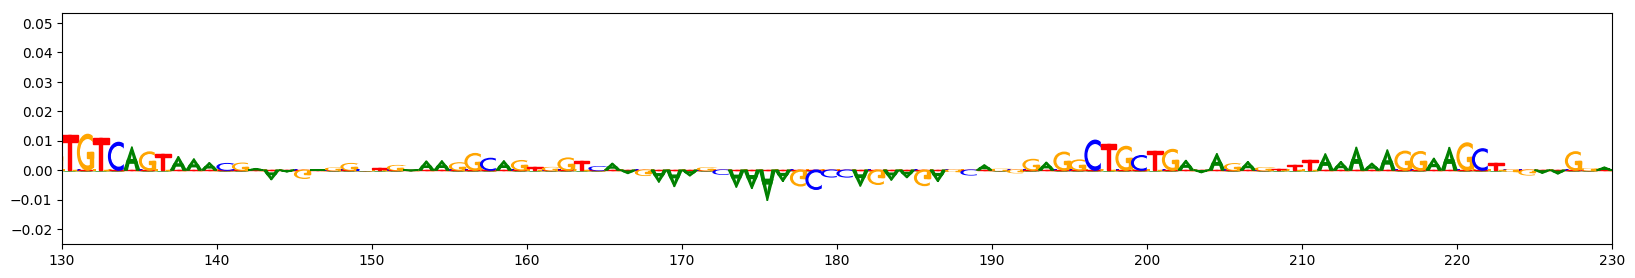

Index:  32  Importance:  -0.007305144999999999   chr11 : 33870655 - 33871155


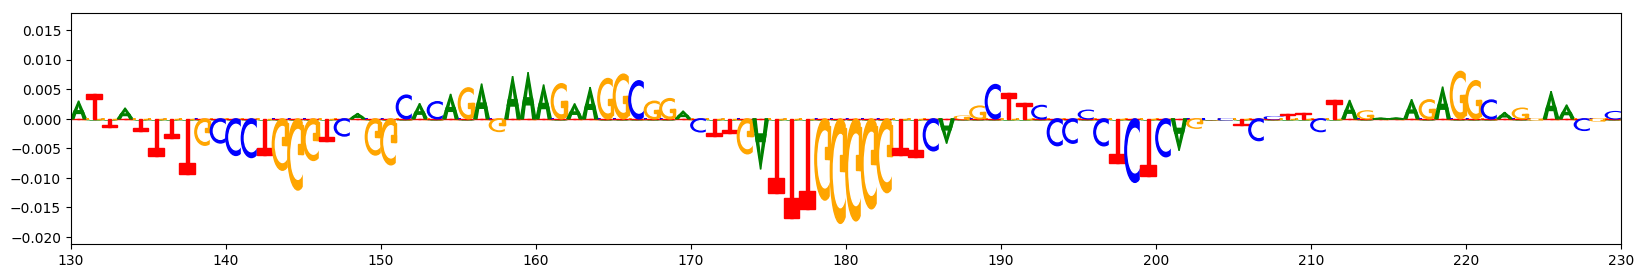

Index:  12  Importance:  -0.11157849139999998   chr11 : 33869934 - 33870434


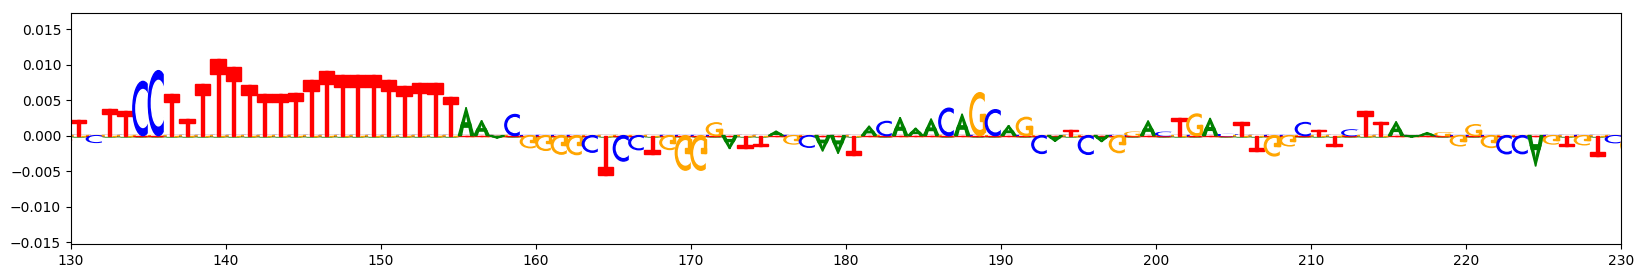

Index:  20  Importance:  -0.15166789523000002   chr11 : 33869341 - 33869841


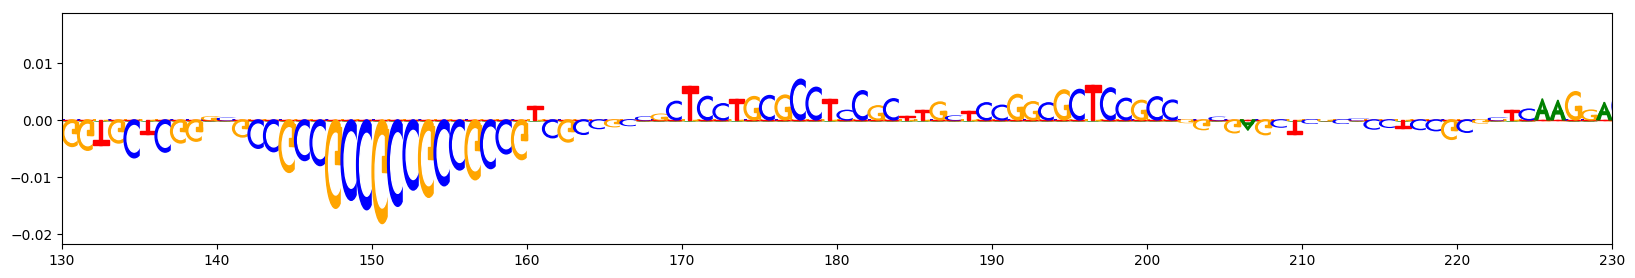

Index:  64  Importance:  -0.1682164356000001   chr11 : 34105726 - 34106226


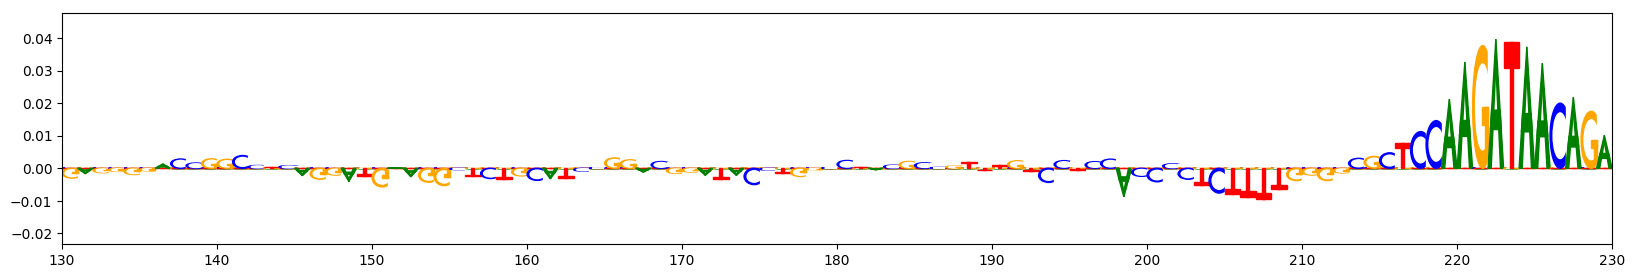

Index:  68  Importance:  -0.2504438144300001   chr11 : 34439100 - 34439600


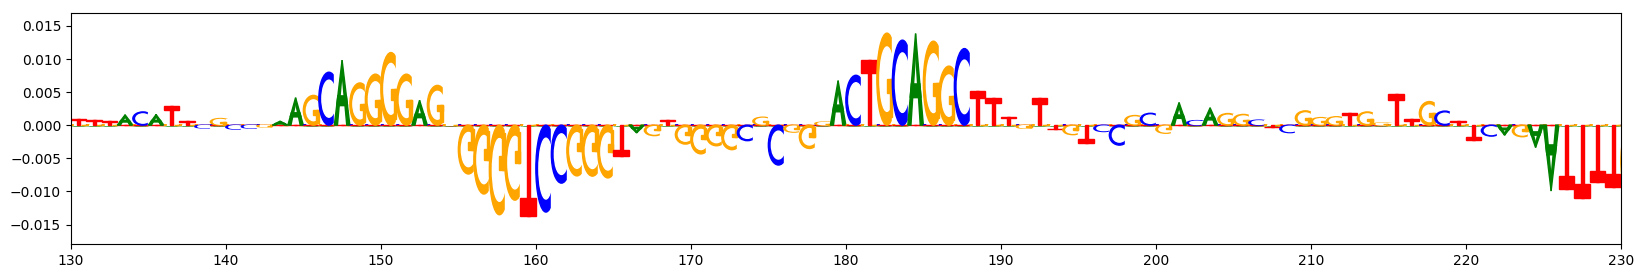

In [8]:
for idx in seq_df.iloc[:20]['index']:
    print("Index: ", idx, " Importance: ", seq_df.at[idx, 'score'], ' ',
          seq_df.at[idx, 'chr'], ':', seq_df.at[idx, 'start'], '-', seq_df.at[idx, 'end'])
    ylim = plot_weights(imp_scores[idx], subticks_frequency=10, xlim=(130,230))